**Basic PLS-DA model**

Direction before running this code:

•	Remove the “Sample ID” column from the all the partitioned data sets.

•	Rename the “Fertility status” column as “Ref” in all sets.

•	Run the PLS_DA_Fertility_model code and change files paths accordingly.



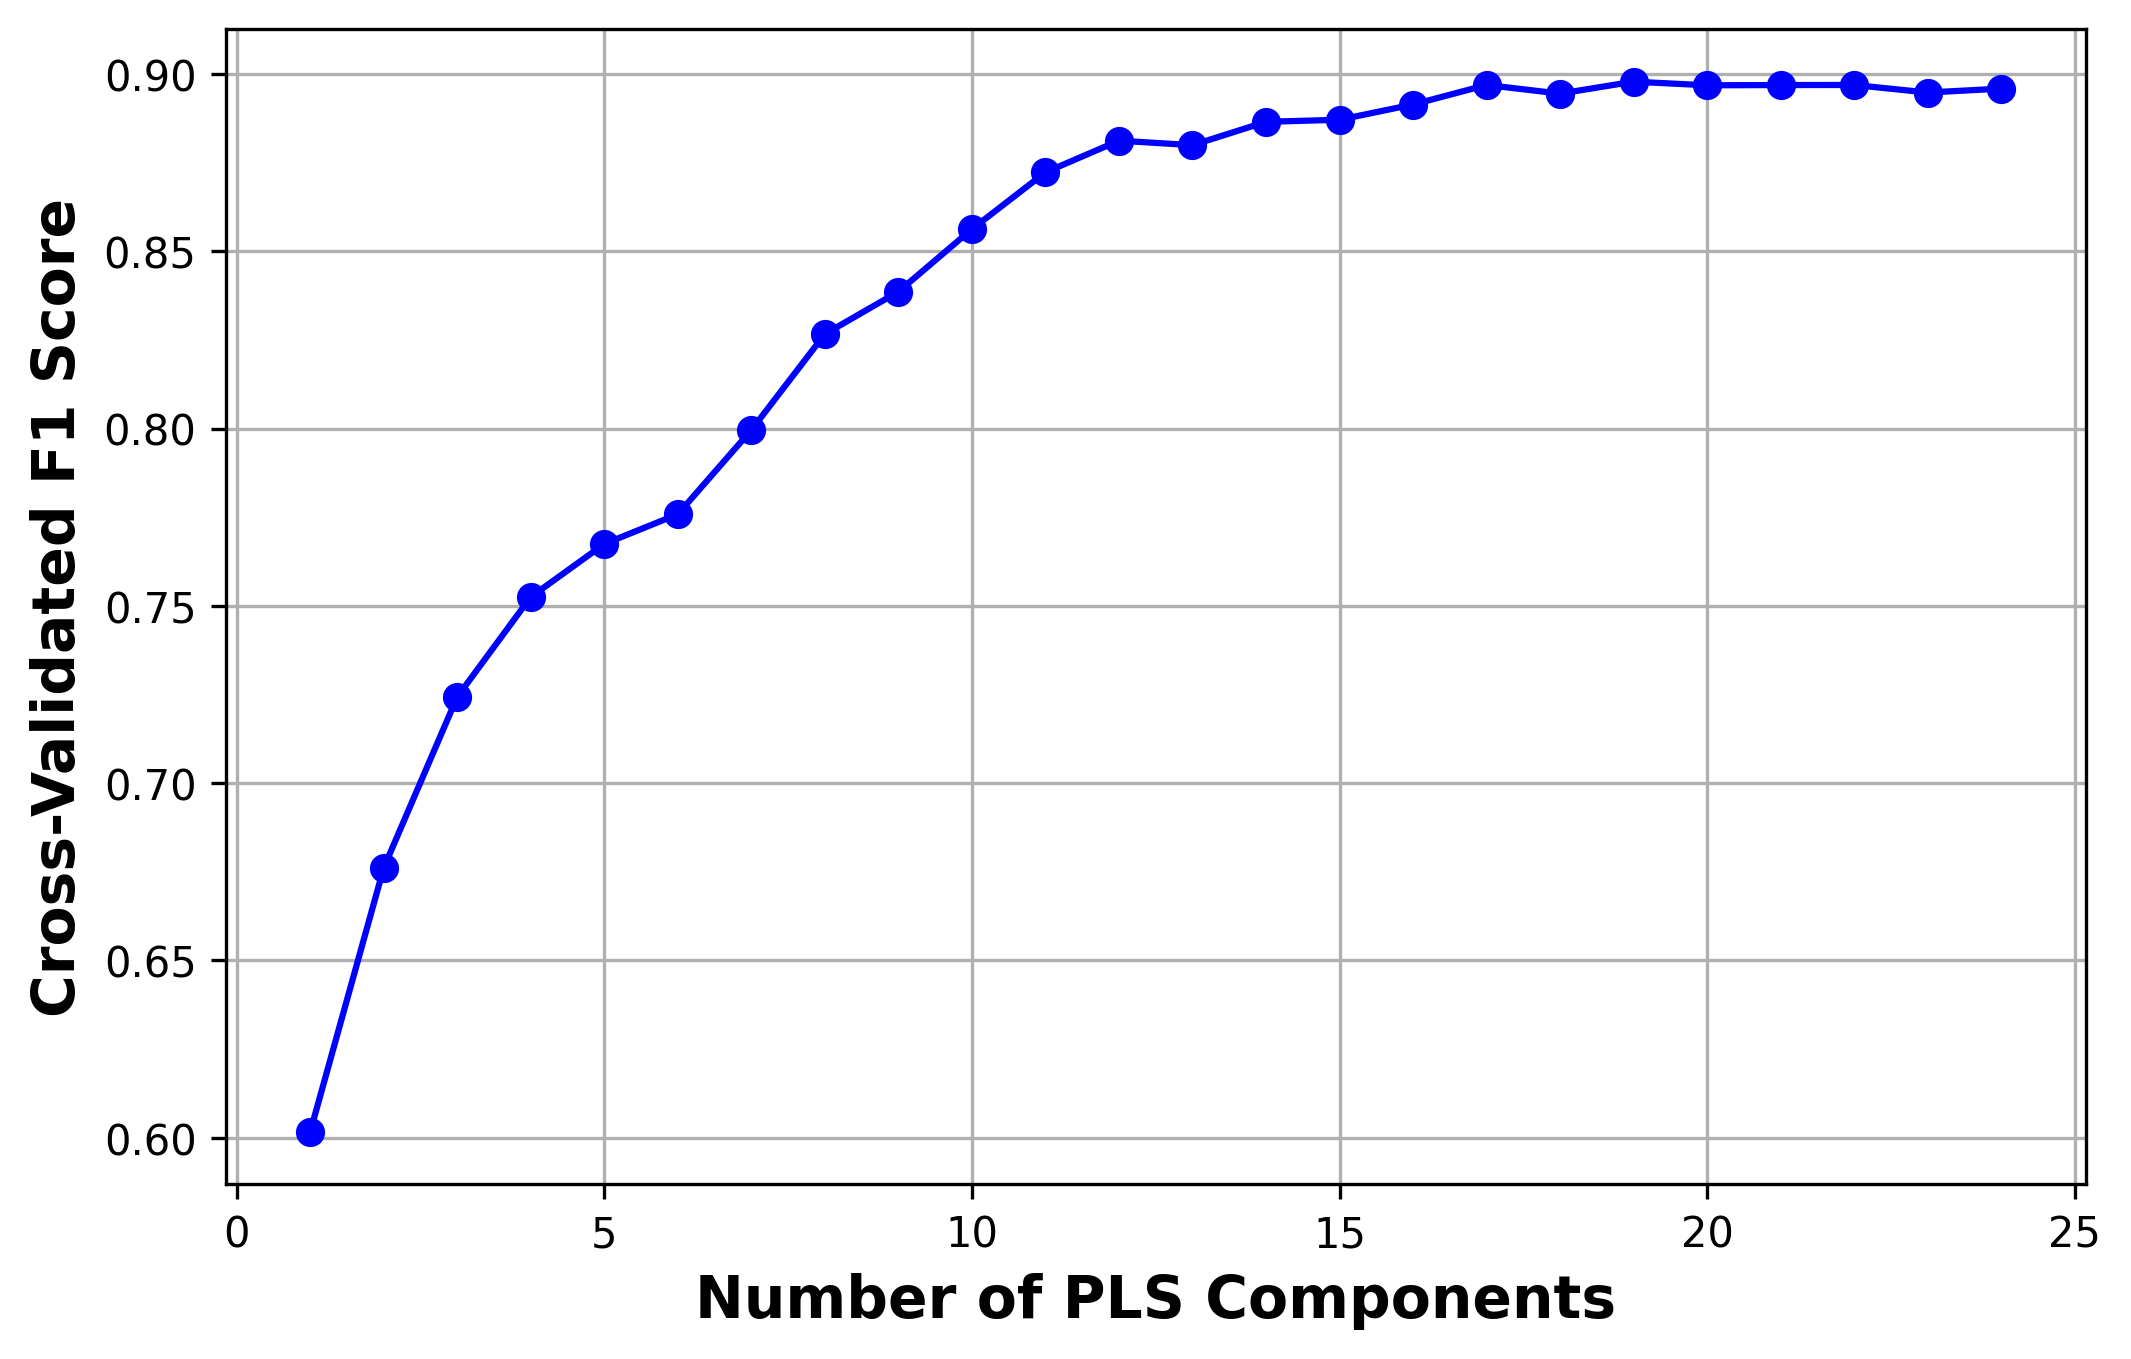

Optimal number of PLS components based on F1 Score: 19
{'Calibration': {'Accuracy': 0.9091967403958091, 'Precision': 0.9050925925925926, 'Recall': 0.9135514018691588, 'F1': 0.9093023255813953}, 'Cross-Validation': {'Accuracy': 0.8987194412107101, 'Precision': 0.8937644341801386, 'Recall': 0.9042056074766355, 'F1': 0.8989547038327527}, 'Validation': {'Accuracy': 0.8858695652173914, 'Precision': 0.8585858585858586, 'Recall': 0.9239130434782609, 'F1': 0.8900523560209425}}


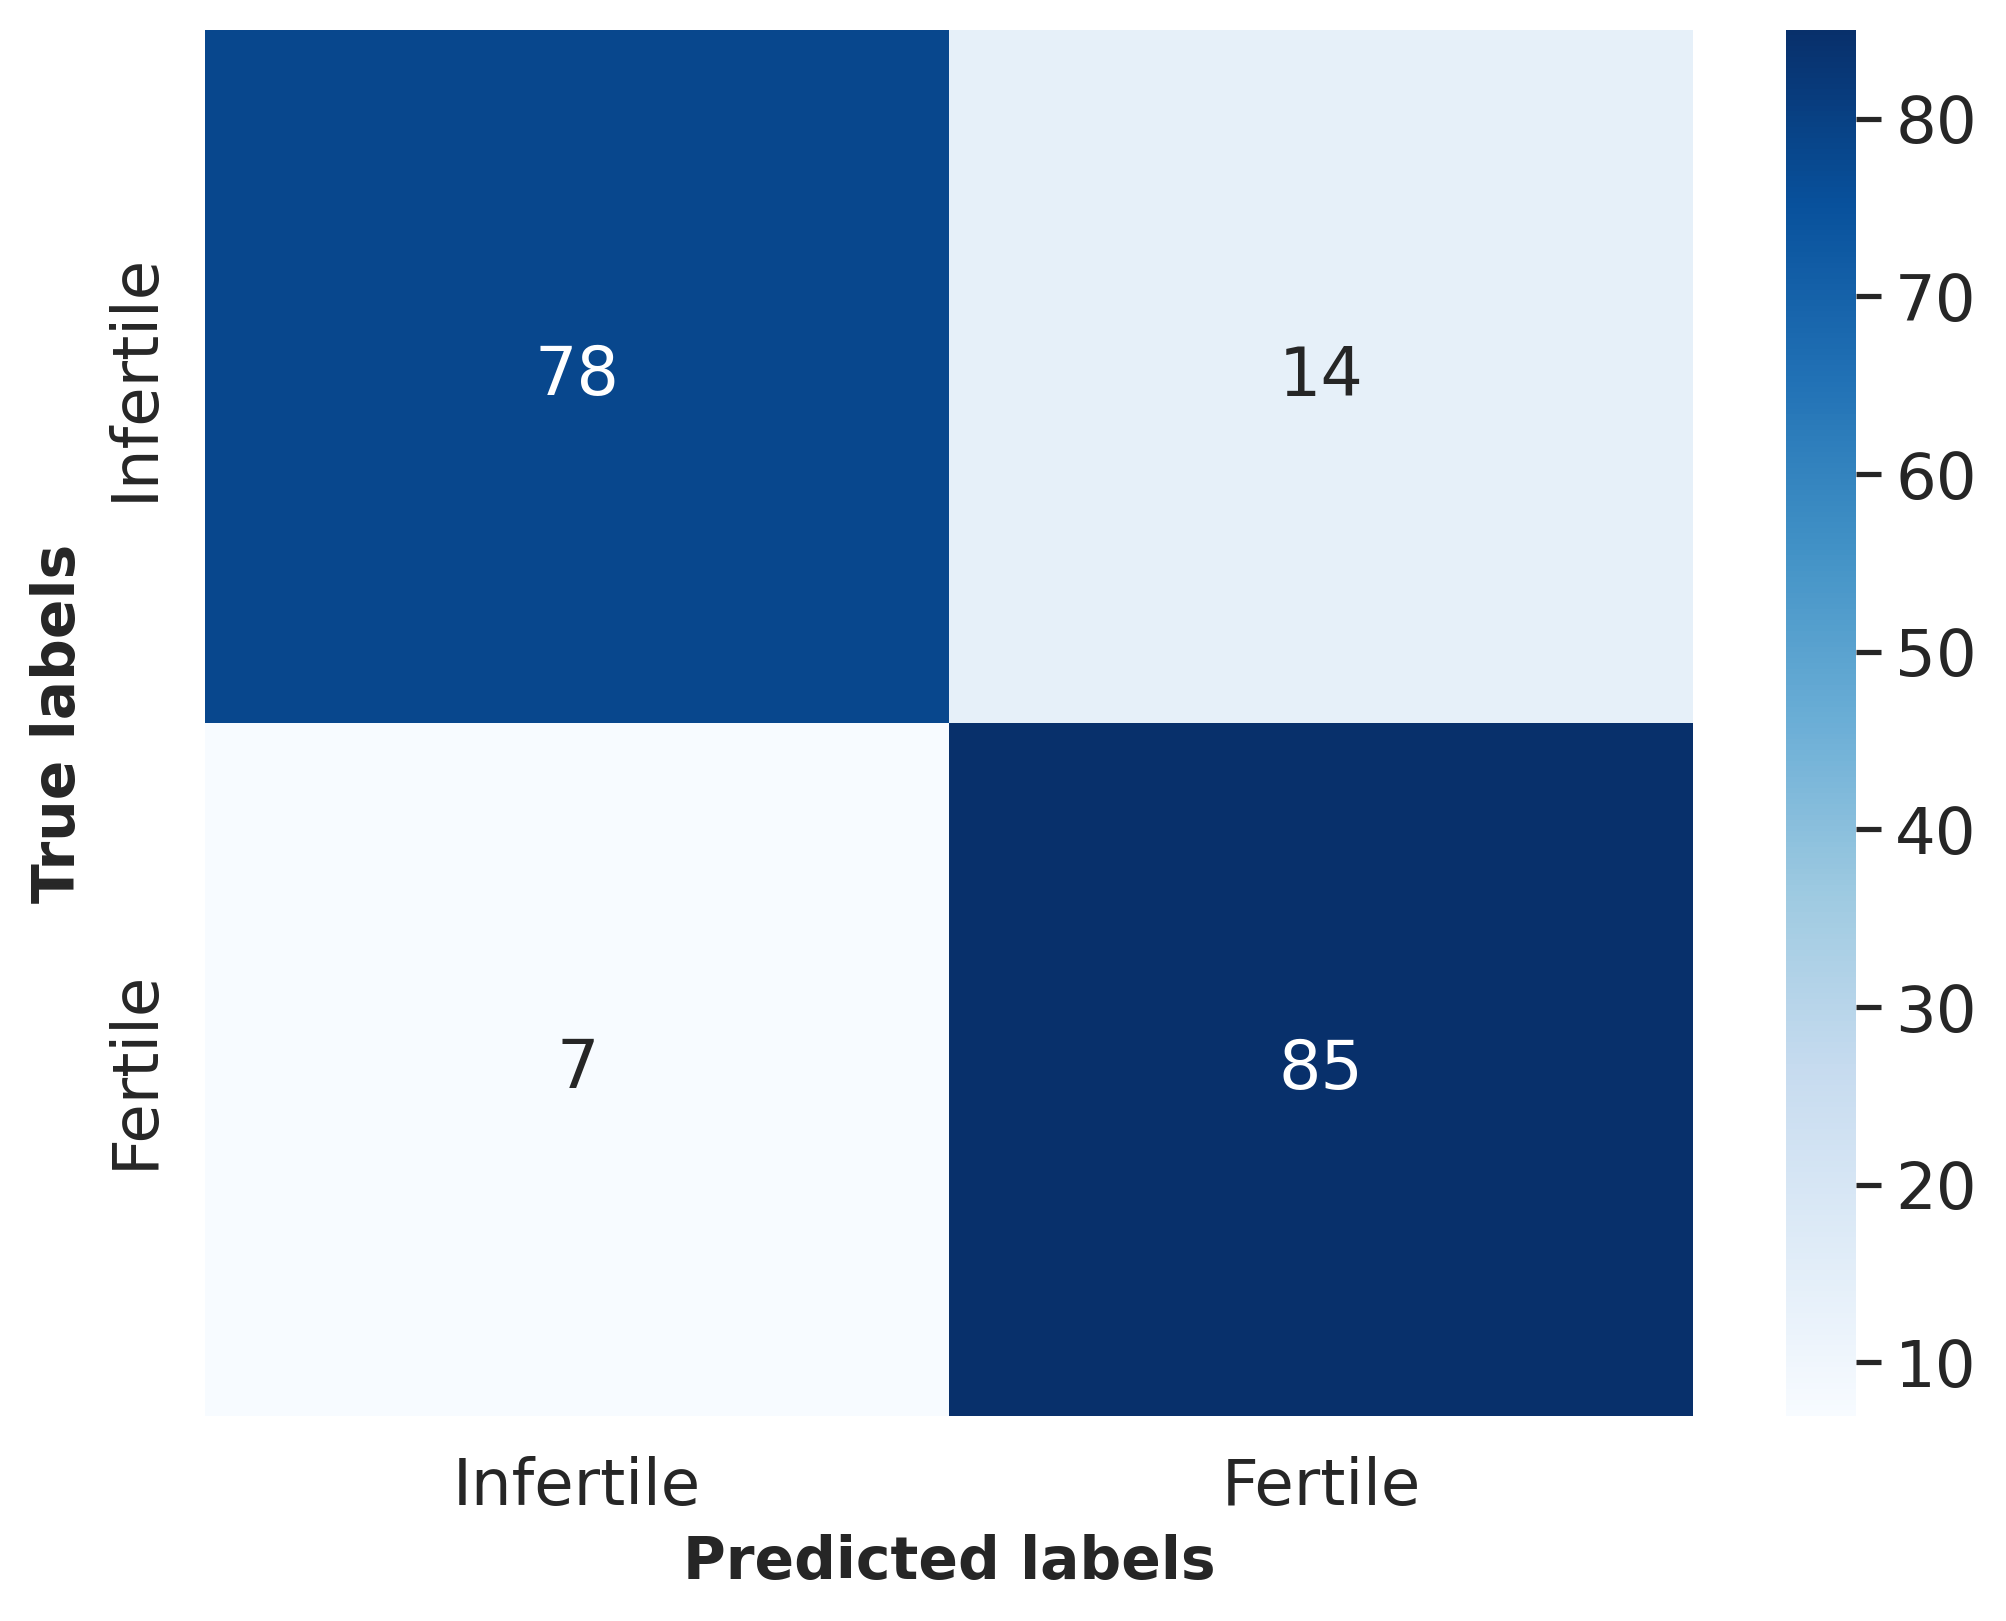

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Load the calibration and validation data
calibration_file_path = '/content/Cal_Stratified.csv' ### Change the calibration path
validation_file_path = '/content/Val_Stratified.csv'   ### Change the validation/test file path

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal = calibration_data.drop(columns=['Ref']).values
y_cal = calibration_data['Ref'].values
X_val = validation_data.drop(columns=['Ref']).values
y_val = validation_data['Ref'].values

# Encode the target variable
label_encoder = LabelEncoder()
y_cal_encoded = label_encoder.fit_transform(y_cal).flatten()  # Ensure y is 1D
y_val_encoded = label_encoder.transform(y_val).flatten()

# Standardize the data
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal)
X_val_scaled = scaler.transform(X_val)

# Define a custom PLS transformer to ensure proper transformation
class PLSExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)

    def fit(self, X, y):
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)  # Ensure 2D shape (samples × components)

# Determine the optimal number of PLS components using **F1 Score**
n_components_range = range(1, 25)  ############ Adjust as needed
cv = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []
for n in n_components_range:
    pls_da_pipeline = Pipeline(steps=[
        ('pls', PLSExtractor(n_components=n)),
        ('logistic', LogisticRegression(random_state=42, max_iter=500))
    ])
    scores = cross_val_score(pls_da_pipeline, X_cal_scaled, y_cal_encoded, cv=cv, scoring=make_scorer(f1_score))
    f1_scores.append(np.mean(scores))

# Plot PLS component selection using F1 score
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(n_components_range, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components', fontsize=14, fontweight='bold')
plt.ylabel('Cross-Validated F1 Score', fontsize=14, fontweight='bold')
#plt.title('PLS Component Selection (F1 Score)', fontsize=16, fontweight='bold')
plt.grid()
plt.show()

# Select the optimal number of components based on the highest F1 score
optimal_n_components = n_components_range[np.argmax(f1_scores)]
print(f'Optimal number of PLS components based on F1 Score: {optimal_n_components}')

# Build final PLS-DA model using the optimal number of components
pls_da_model = Pipeline(steps=[
    ('pls', PLSExtractor(n_components=optimal_n_components)),
    ('logistic', LogisticRegression(random_state=42, max_iter=500))
])

# Fit the model on the calibration set
pls_da_model.fit(X_cal_scaled, y_cal_encoded)

# Perform 10-fold cross-validation on the calibration set
y_cv_pred = cross_val_predict(pls_da_model, X_cal_scaled, y_cal_encoded, cv=cv)

# Predict on the validation set
y_val_pred = pls_da_model.predict(X_val_scaled).round().astype(int)

# Classification metrics function
def calculate_classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Metrics for calibration set
metrics_cal = calculate_classification_metrics(y_cal_encoded, pls_da_model.predict(X_cal_scaled).round().astype(int))

# Metrics for cross-validation
metrics_cv = calculate_classification_metrics(y_cal_encoded, y_cv_pred)

# Metrics for validation set
metrics_val = calculate_classification_metrics(y_val_encoded, y_val_pred)

# Display the results
results = {
    "Calibration": metrics_cal,
    "Cross-Validation": metrics_cv,
    "Validation": metrics_val
}
print(results)

# Confusion matrix for the validation set
cm = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6), dpi=300)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Infertile', 'Fertile'],
            yticklabels=['Infertile', 'Fertile'],
            annot_kws={"size": 16})
plt.xlabel('Predicted labels', fontsize=14, fontweight='bold')
plt.ylabel('True labels', fontsize=14, fontweight='bold')
plt.show()

**Confusion matrix for Training/Calibration set**

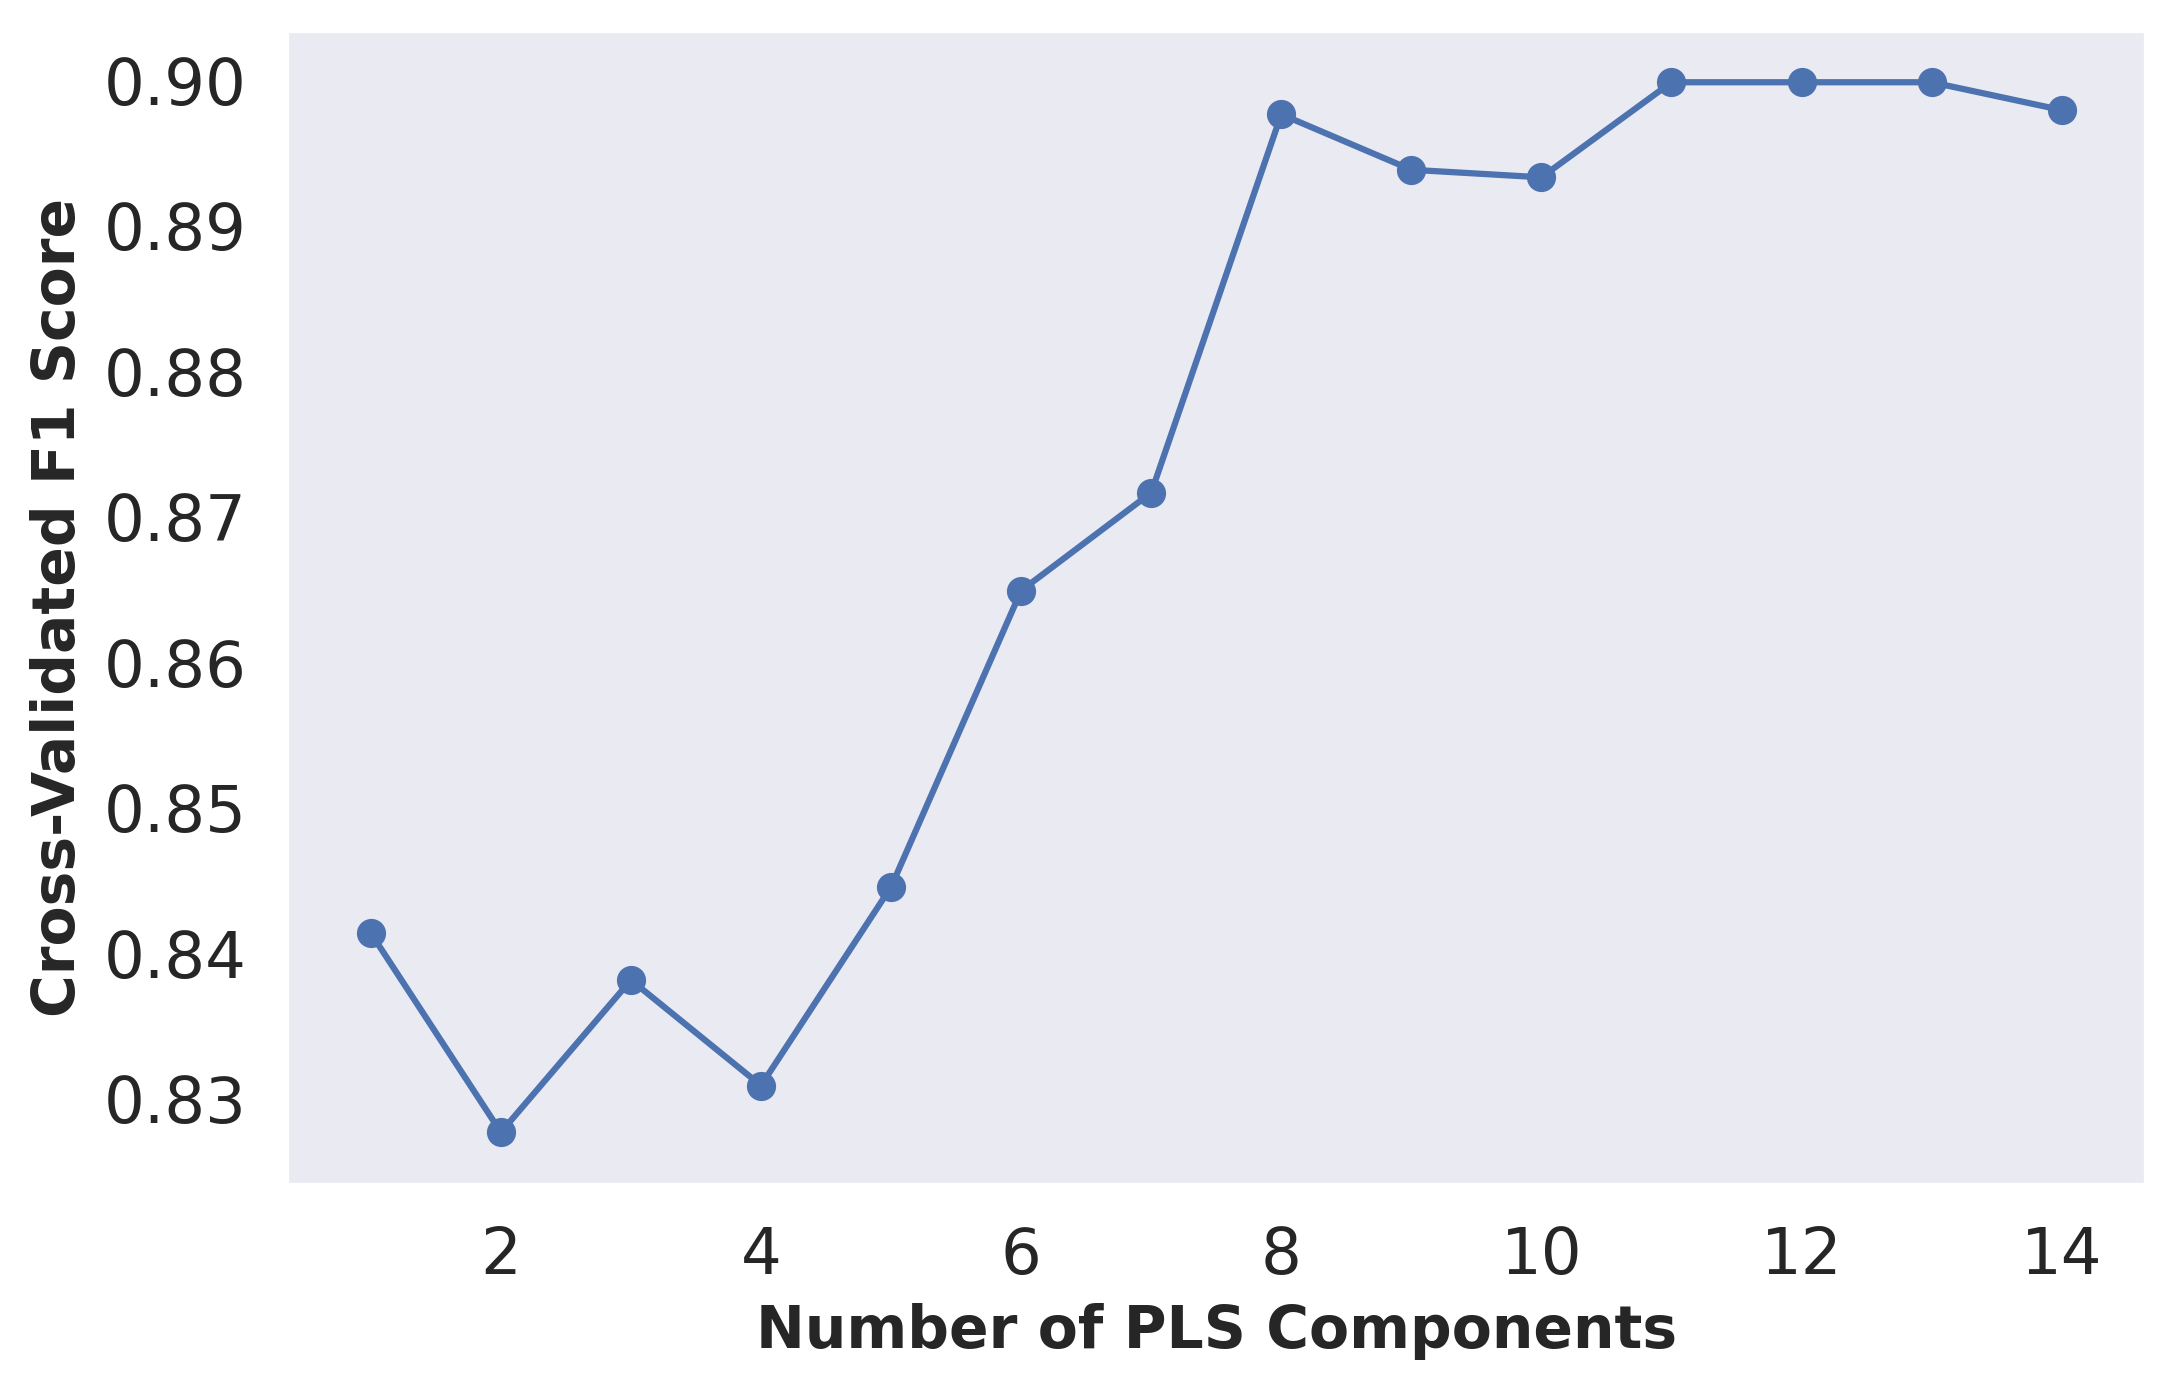

Optimal number of PLS components based on F1 Score: 11
{'Calibration': {'Accuracy': 0.9066666666666666, 'Precision': 0.9210526315789473, 'Recall': 0.9545454545454546, 'F1': 0.9375}, 'Cross-Validation': {'Accuracy': 0.86, 'Precision': 0.8938053097345132, 'Recall': 0.9181818181818182, 'F1': 0.905829596412556}, 'Validation': {'Accuracy': 0.9066666666666666, 'Precision': 0.9137931034482759, 'Recall': 0.9636363636363636, 'F1': 0.9380530973451328}}


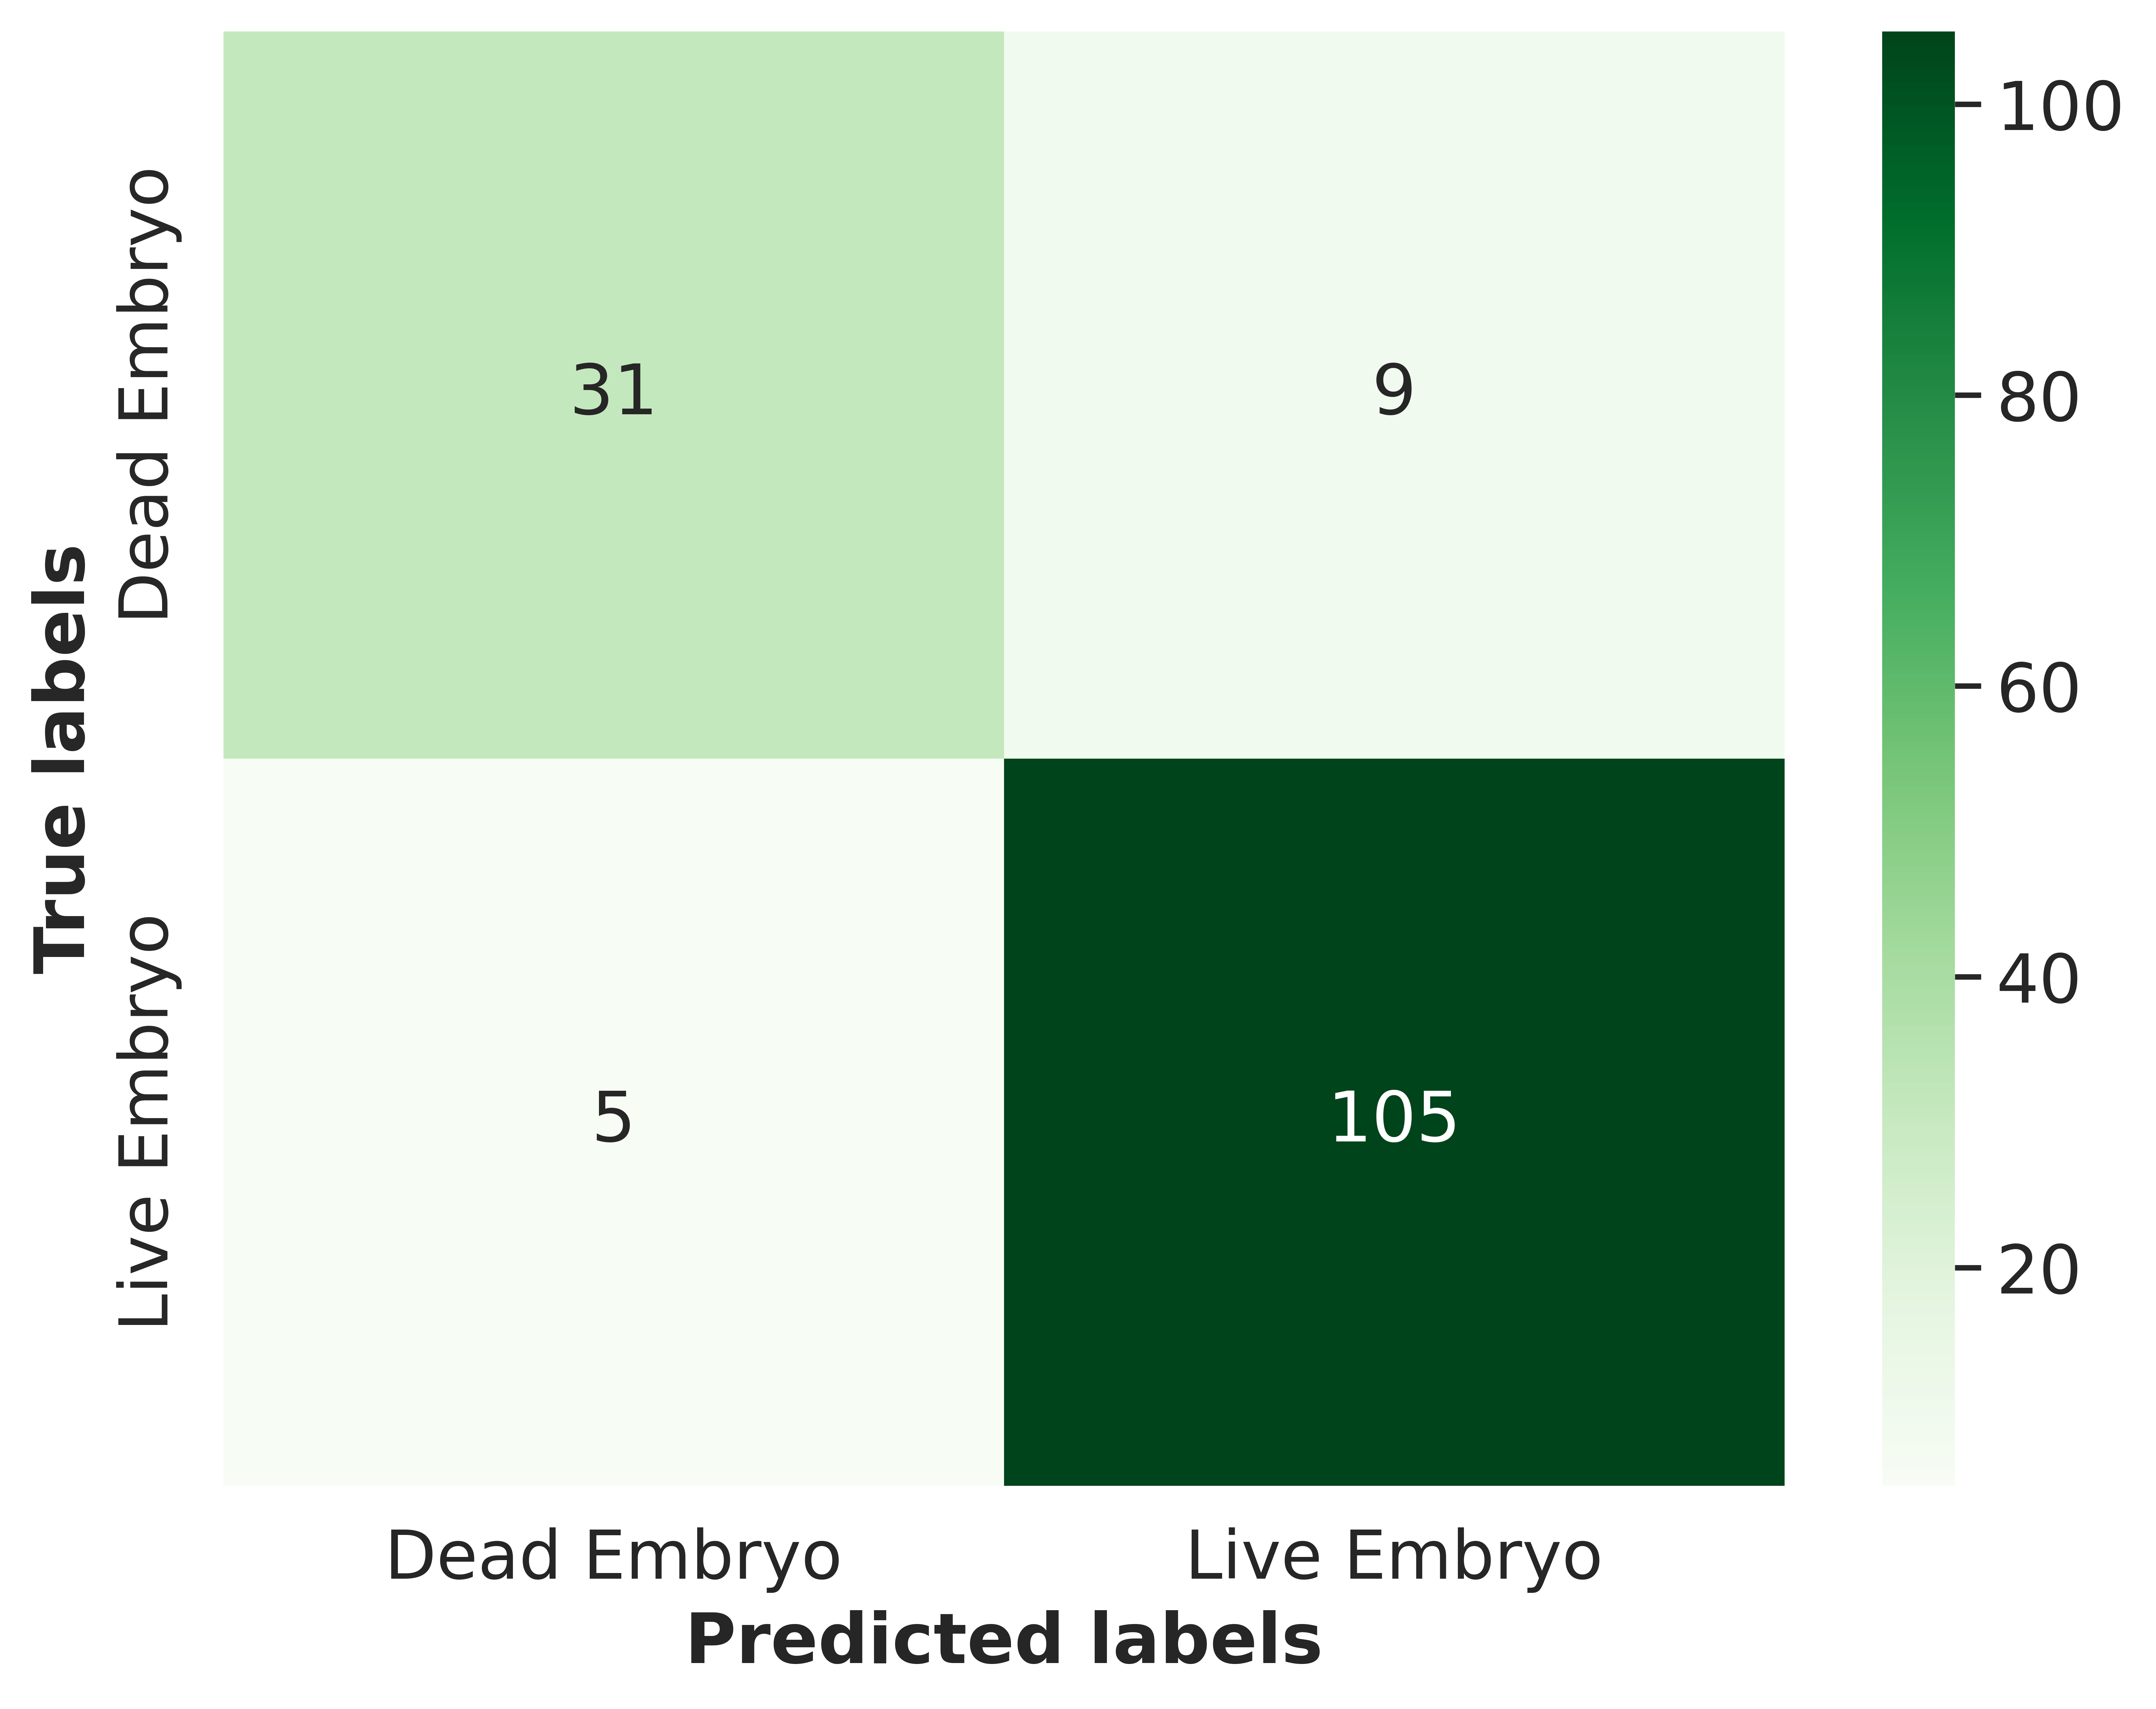

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Load the calibration and validation data
calibration_file_path = '/content/Calibration_Rand.csv'
validation_file_path = '/content/Validation1_Rand.csv'

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare the calibration and validation data
X_cal = calibration_data.drop(columns=['Ref']).values
y_cal = calibration_data['Ref'].values
X_val = validation_data.drop(columns=['Ref']).values
y_val = validation_data['Ref'].values

# Encode the target variable
label_encoder = LabelEncoder()
y_cal_encoded = label_encoder.fit_transform(y_cal).flatten()
y_val_encoded = label_encoder.transform(y_val).flatten()

# Standardize the data
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal)
X_val_scaled = scaler.transform(X_val)

# Define a custom PLS transformer
class PLSExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)

    def fit(self, X, y):
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)  # Ensure 2D output

# Determine the optimal number of PLS components using F1 Score
n_components_range = range(1, 15)  # Adjust if needed
cv = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []
for n in n_components_range:
    pls_da_pipeline = Pipeline(steps=[
        ('pls', PLSExtractor(n_components=n)),
        ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))  # Adjust solver
    ])
    scores = cross_val_score(pls_da_pipeline, X_cal_scaled, y_cal_encoded, cv=cv, scoring=make_scorer(f1_score))
    f1_scores.append(np.mean(scores))

# Plot PLS component selection using F1 score
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(n_components_range, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components', fontsize=14, fontweight='bold')
plt.ylabel('Cross-Validated F1 Score', fontsize=14, fontweight='bold')
#plt.title('PLS Component Selection (F1 Score)', fontsize=16, fontweight='bold')
plt.grid()
plt.show()

# Select the optimal number of components
optimal_n_components = n_components_range[np.argmax(f1_scores)]
print(f'Optimal number of PLS components based on F1 Score: {optimal_n_components}')

# Build final PLS-DA model using the optimal number of components
pls_da_model = Pipeline(steps=[
    ('pls', PLSExtractor(n_components=optimal_n_components)),
    ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))
])

# Fit the model on the calibration set
pls_da_model.fit(X_cal_scaled, y_cal_encoded)

# Perform 10-fold cross-validation on the calibration set
y_cv_pred = cross_val_predict(pls_da_model, X_cal_scaled, y_cal_encoded, cv=cv)

# Predict on the calibration set
y_cal_pred = pls_da_model.predict(X_cal_scaled).round().astype(int)

# Predict on the validation set
y_val_pred = pls_da_model.predict(X_val_scaled).round().astype(int)

# Classification metrics function
def calculate_classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Metrics for calibration set
metrics_cal = calculate_classification_metrics(y_cal_encoded, y_cal_pred)

# Metrics for cross-validation
metrics_cv = calculate_classification_metrics(y_cal_encoded, y_cv_pred)

# Metrics for validation set
metrics_val = calculate_classification_metrics(y_val_encoded, y_val_pred)

# Display the results
results = {
    "Calibration": metrics_cal,
    "Cross-Validation": metrics_cv,
    "Validation": metrics_val
}
print(results)

# Confusion matrix for the calibration set
conf_matrix_cal = confusion_matrix(y_cal_encoded, y_cal_pred)

# Plot confusion matrix for calibration set with 'Greens' colormap
plt.figure(figsize=(8, 6), dpi=1000)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_cal, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Dead Embryo', 'Live Embryo'],
            yticklabels=['Dead Embryo', 'Live Embryo'],
            annot_kws={"size": 16})
plt.xlabel('Predicted labels', fontsize=16, fontweight='bold')
plt.ylabel('True labels', fontsize=16, fontweight='bold')
plt.show()

**MSC spectral pre-processing+ PLS-DA model**

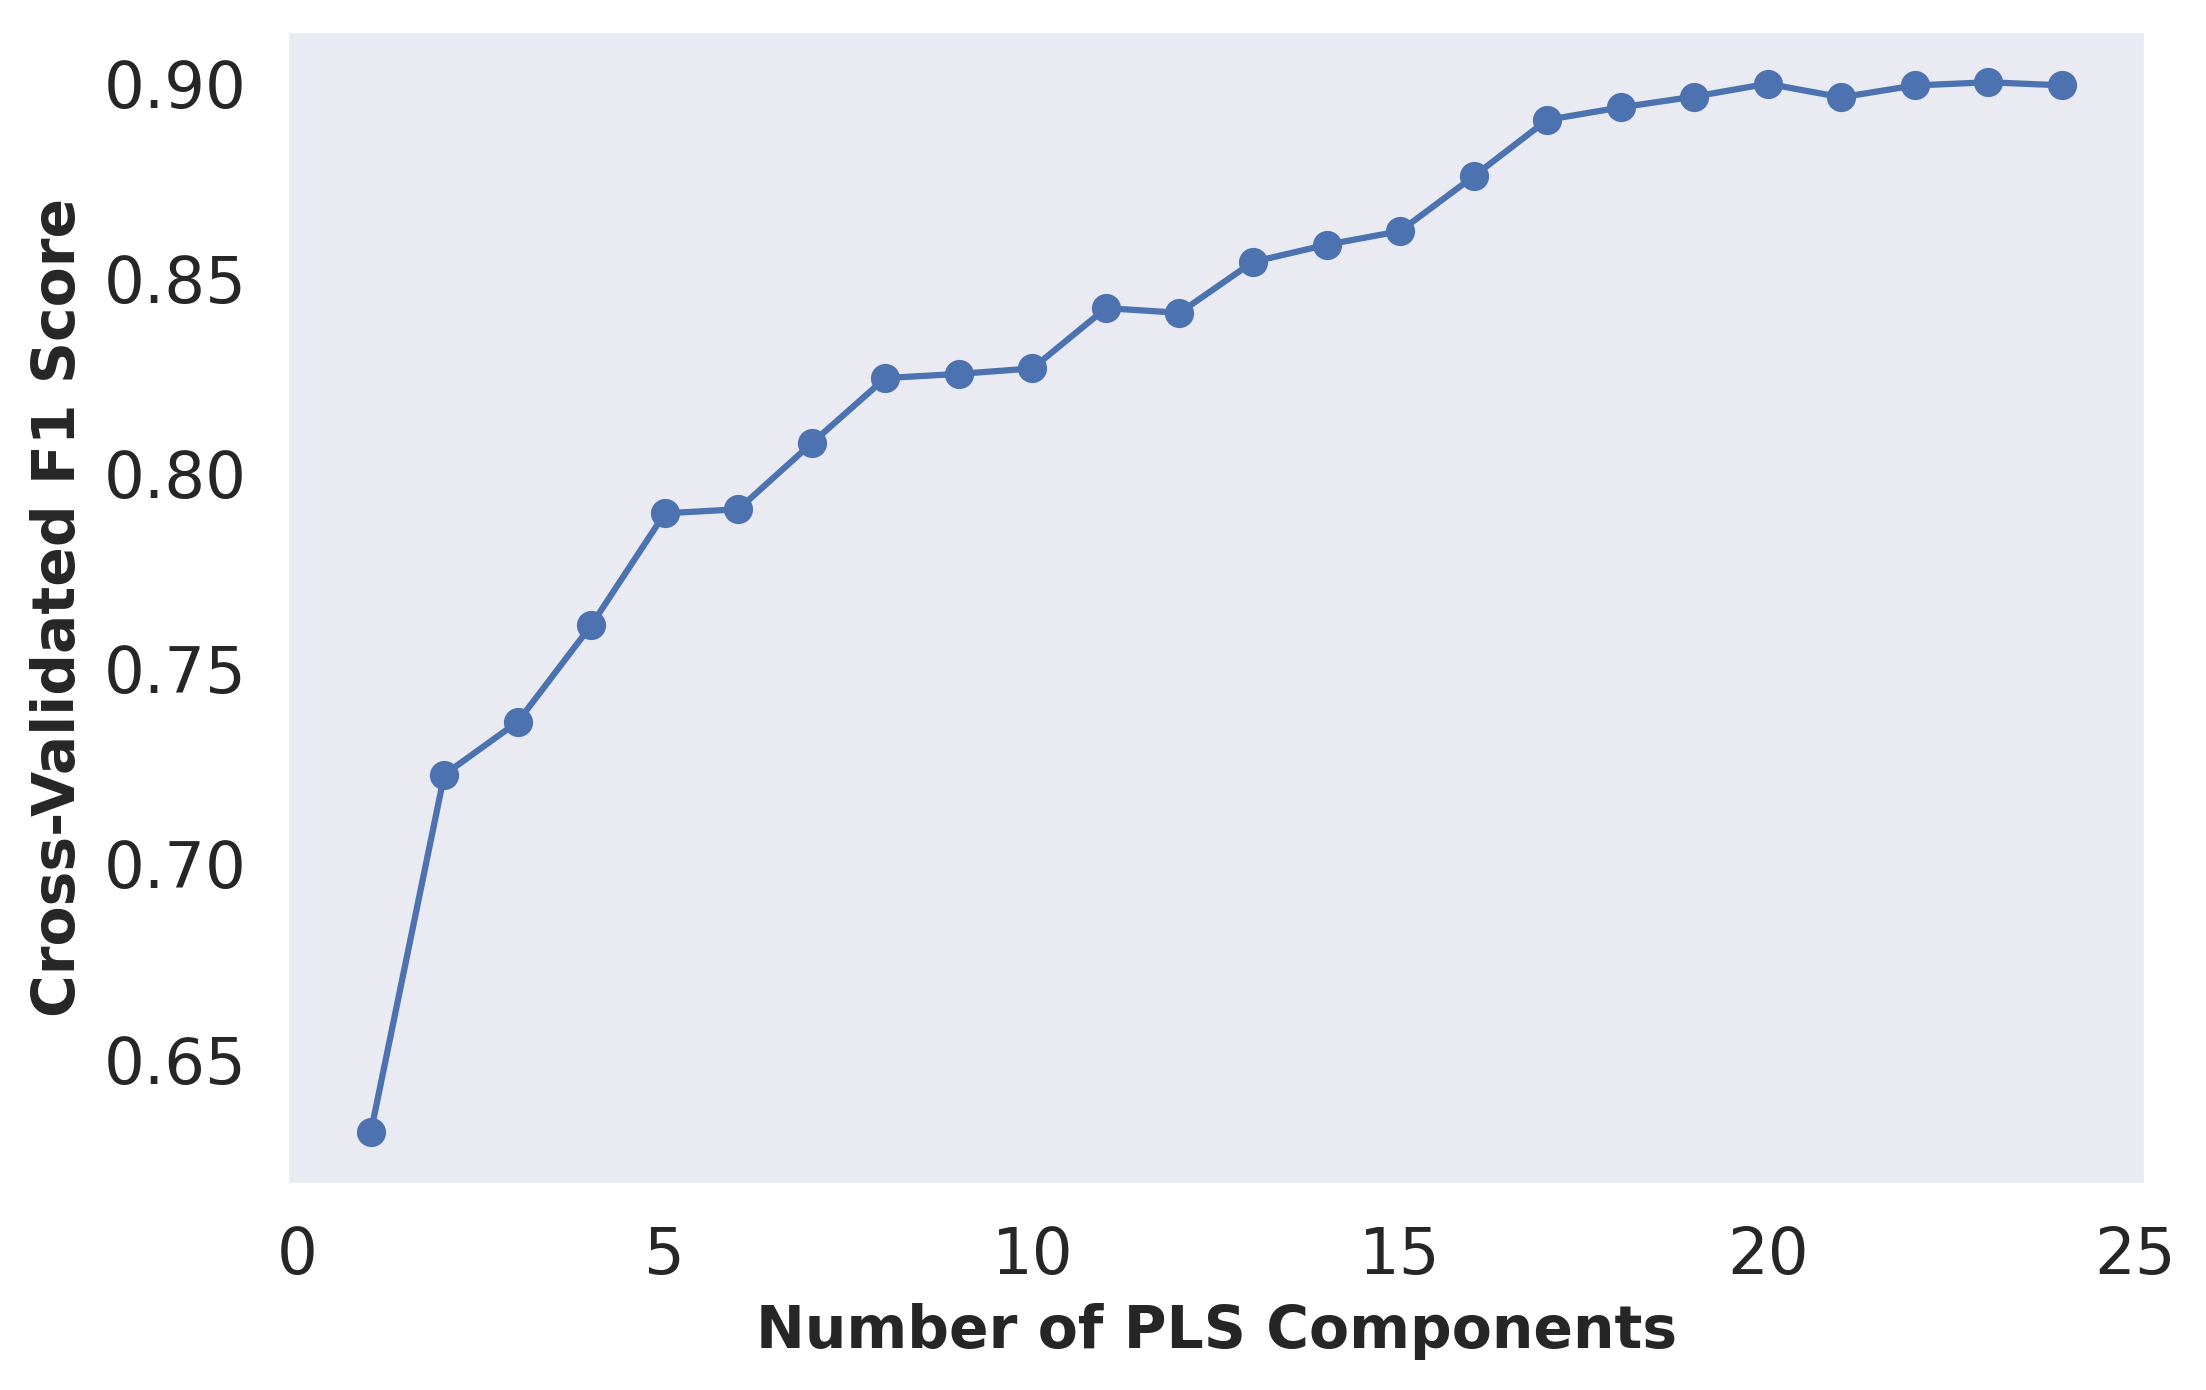

Optimal number of PLS components based on F1 Score: 23
{'Calibration': {'Accuracy': 0.9185098952270081, 'Precision': 0.9182242990654206, 'Recall': 0.9182242990654206, 'F1': 0.9182242990654206}, 'Cross-Validation': {'Accuracy': 0.9010477299185099, 'Precision': 0.9016393442622951, 'Recall': 0.8995327102803738, 'F1': 0.9005847953216374}, 'Validation': {'Accuracy': 0.9027027027027027, 'Precision': 0.8936170212765957, 'Recall': 0.9130434782608695, 'F1': 0.9032258064516129}}


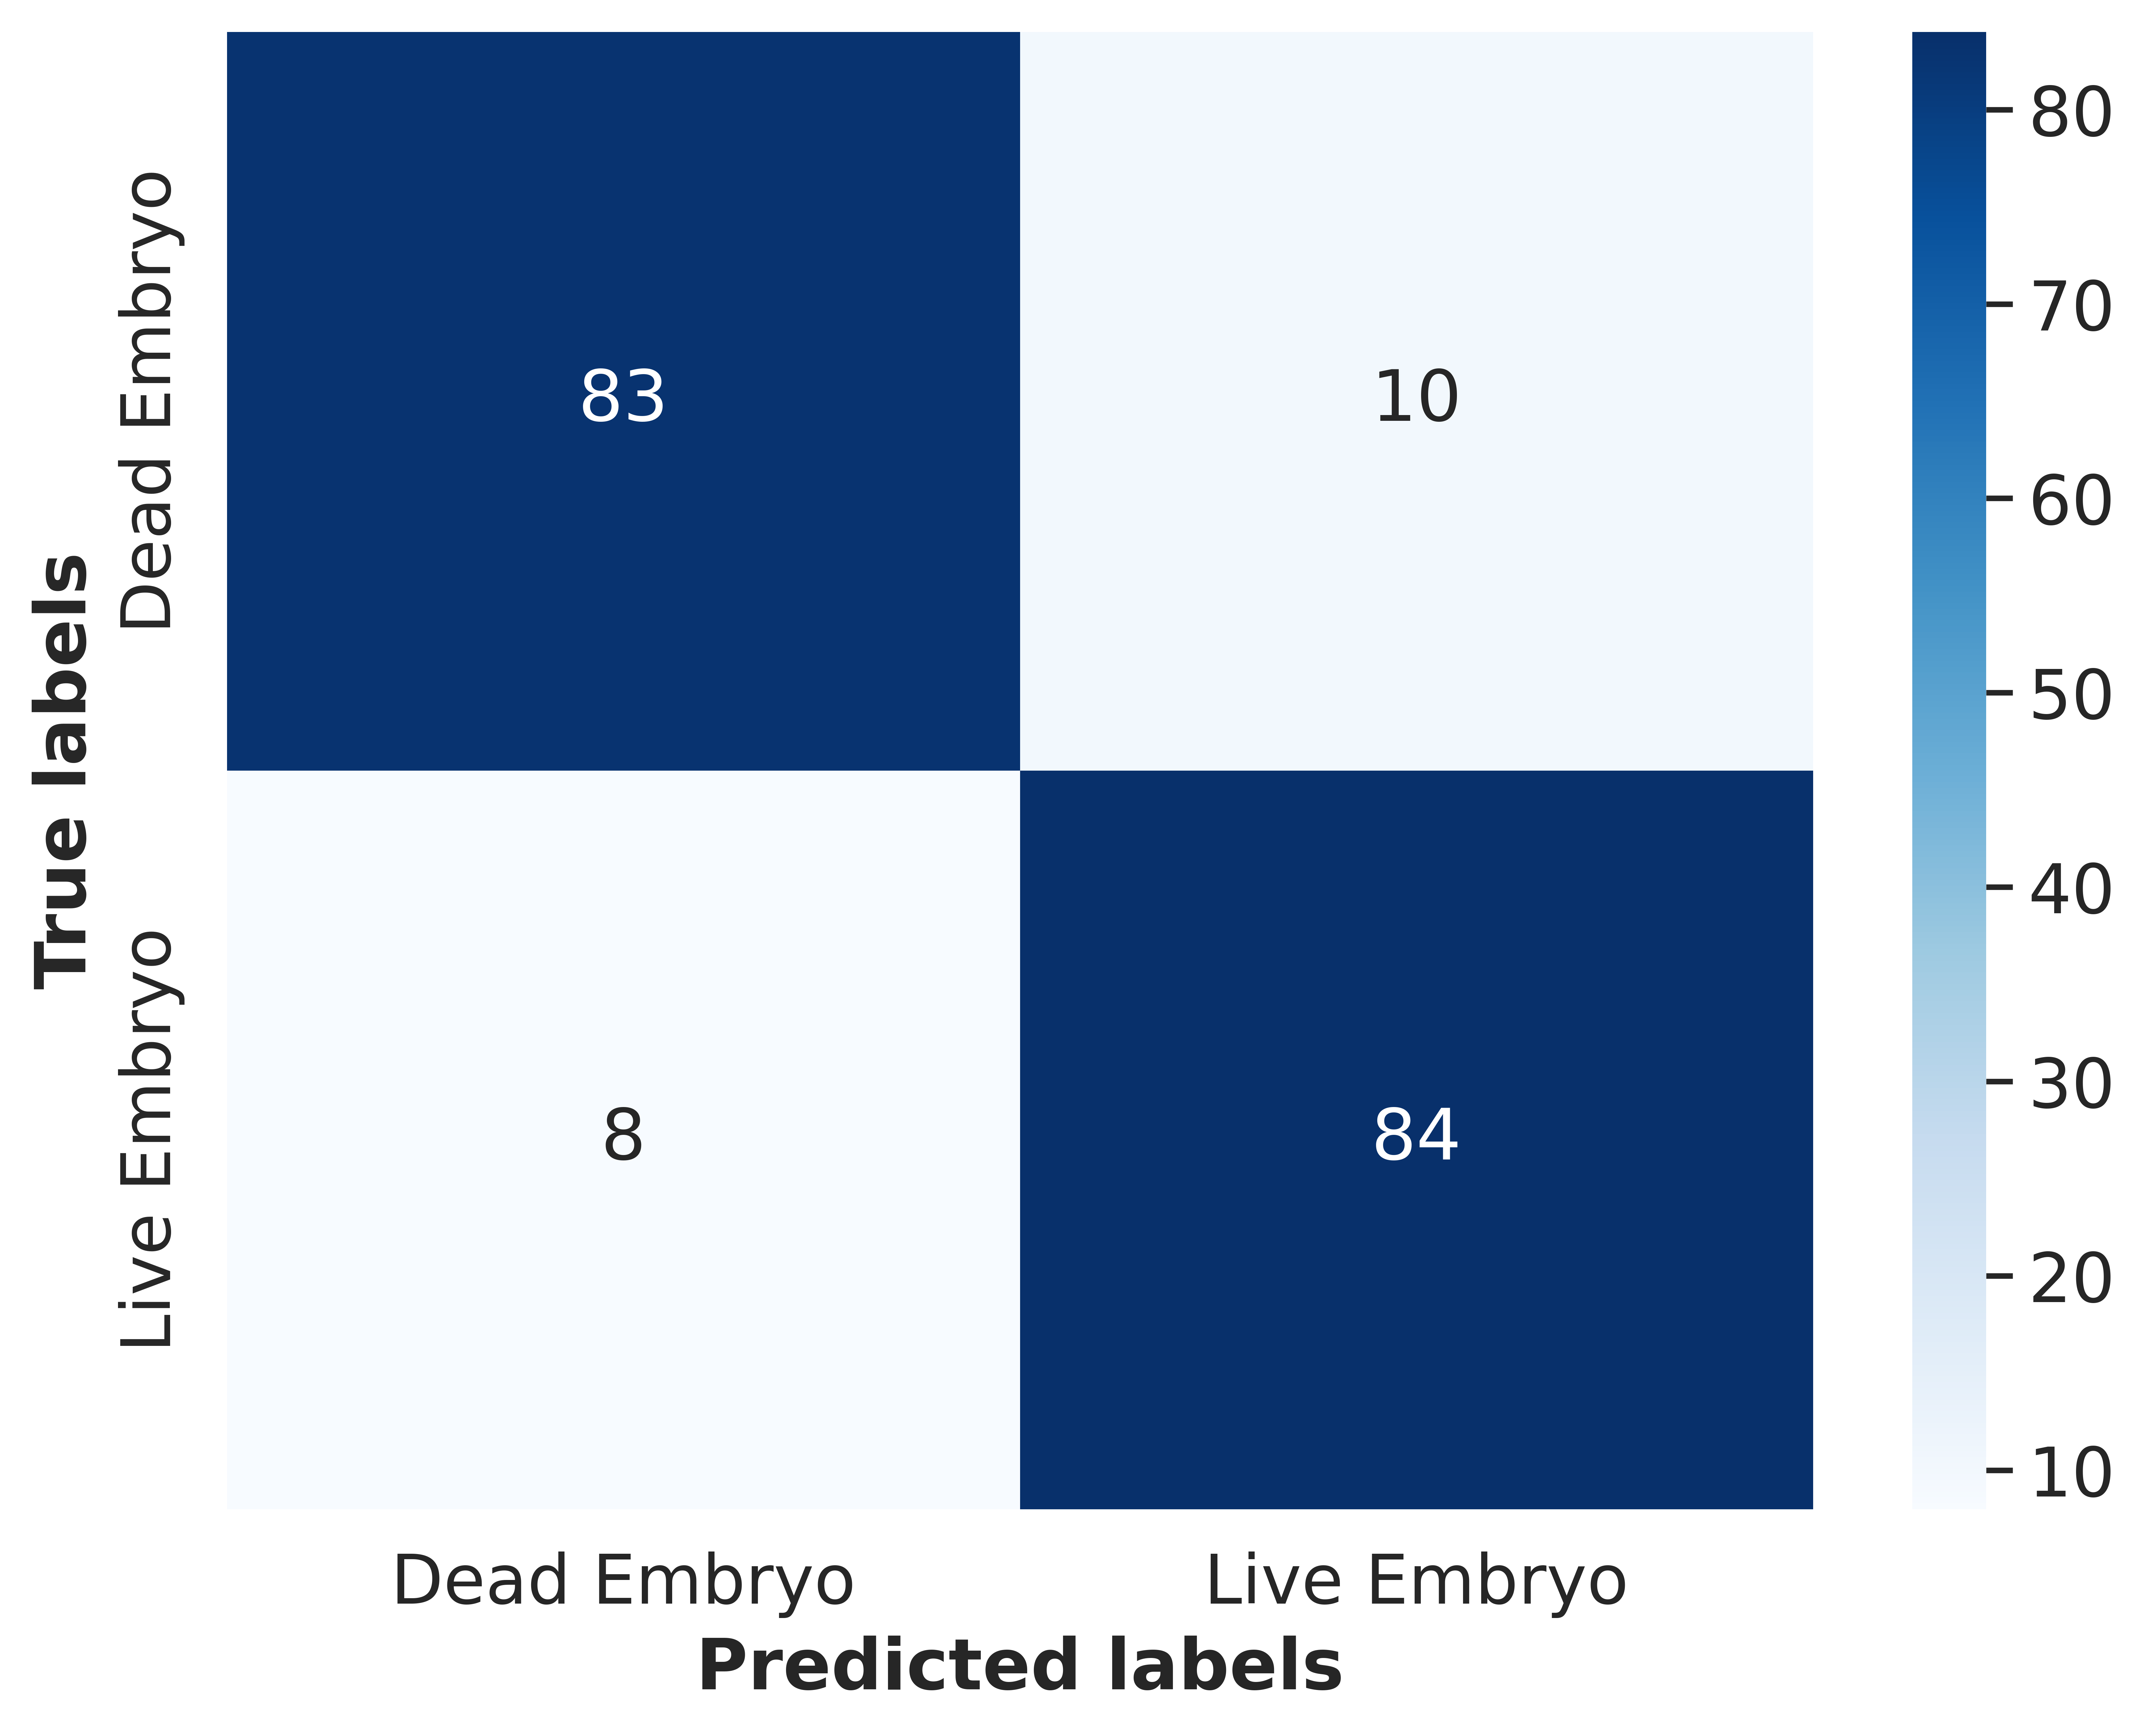

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Manually select features (columns) for calibration and validation
#columns_to_keep = ['Ref','538.93', '551.48', '564.08', '568.28', '574.58', '576.68', '578.79', '580.9', '597.77', '687.17']  ### make a comment before this line if you want full featured model

# Function for Multiplicative Scatter Correction (MSC)
def msc(input_data, reference=None):
    """Apply Multiplicative Scatter Correction (MSC)."""
    if reference is None:
        reference = np.mean(input_data, axis=0)
    corrected_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        fit = np.polyfit(reference, input_data[i, :], 1, full=True)
        corrected_data[i, :] = (input_data[i, :] - fit[0][1]) / fit[0][0]
    return corrected_data

# Load calibration and validation data
calibration_file_path = '/content/Cal_Stratified.csv'
validation_file_path = '/content/Val_Stratified.csv'

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare calibration and validation data
X_cal = calibration_data.drop(columns=['Ref']).values
y_cal = calibration_data['Ref'].values
X_val = validation_data.drop(columns=['Ref']).values
y_val = validation_data['Ref'].values

# Apply MSC transformation
X_cal_msc = msc(X_cal)
X_val_msc = msc(X_val, reference=np.mean(X_cal, axis=0))

# Encode the target variable
label_encoder = LabelEncoder()
y_cal_encoded = label_encoder.fit_transform(y_cal).flatten()
y_val_encoded = label_encoder.transform(y_val).flatten()

# Standardize the data
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal_msc)
X_val_scaled = scaler.transform(X_val_msc)

# Define a custom PLS transformer to ensure correct transformation
class PLSExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)

    def fit(self, X, y):
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)  # Ensure 2D output

# Determine the optimal number of PLS components using F1 Score
n_components_range = range(1, 25)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []
for n in n_components_range:
    pls_da_pipeline = Pipeline(steps=[
        ('pls', PLSExtractor(n_components=n)),
        ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))  # Adjust solver
    ])
    scores = cross_val_score(pls_da_pipeline, X_cal_scaled, y_cal_encoded, cv=cv, scoring=make_scorer(f1_score))
    f1_scores.append(np.mean(scores))

# Plot PLS component selection using F1 score
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(n_components_range, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components', fontsize=14, fontweight='bold')
plt.ylabel('Cross-Validated F1 Score', fontsize=14, fontweight='bold')
#plt.title('PLS Component Selection (F1 Score)', fontsize=16, fontweight='bold')
plt.grid()
plt.show()

# Select optimal number of components
optimal_n_components = n_components_range[np.argmax(f1_scores)]
print(f'Optimal number of PLS components based on F1 Score: {optimal_n_components}')

# Build final PLS-DA model using the optimal number of components
pls_da_model = Pipeline(steps=[
    ('pls', PLSExtractor(n_components=optimal_n_components)),
    ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))
])

# Fit the model on the calibration set
pls_da_model.fit(X_cal_scaled, y_cal_encoded)

# Perform cross-validation
y_cv_pred = cross_val_predict(pls_da_model, X_cal_scaled, y_cal_encoded, cv=cv)

# Predict on the calibration set
y_cal_pred = pls_da_model.predict(X_cal_scaled).round().astype(int)

# Predict on the validation set
y_val_pred = pls_da_model.predict(X_val_scaled).round().astype(int)

# Classification metrics function
def calculate_classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Compute classification metrics
results = {
    "Calibration": calculate_classification_metrics(y_cal_encoded, y_cal_pred),
    "Cross-Validation": calculate_classification_metrics(y_cal_encoded, y_cv_pred),
    "Validation": calculate_classification_metrics(y_val_encoded, y_val_pred)
}

print(results)

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix for validation set with 'Blues' colormap
plt.figure(figsize=(8, 6), dpi=1000)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', ###### chnage cmap=Greens/Blues/Purples for others color confusion matrix for Val 2 set###
            xticklabels=['Dead Embryo', 'Live Embryo'],
            yticklabels=['Dead Embryo', 'Live Embryo'],
            annot_kws={"size": 16})
plt.xlabel('Predicted labels', fontsize=16, fontweight='bold')
plt.ylabel('True labels', fontsize=16, fontweight='bold')
plt.show()

**SNV-PLSDA**

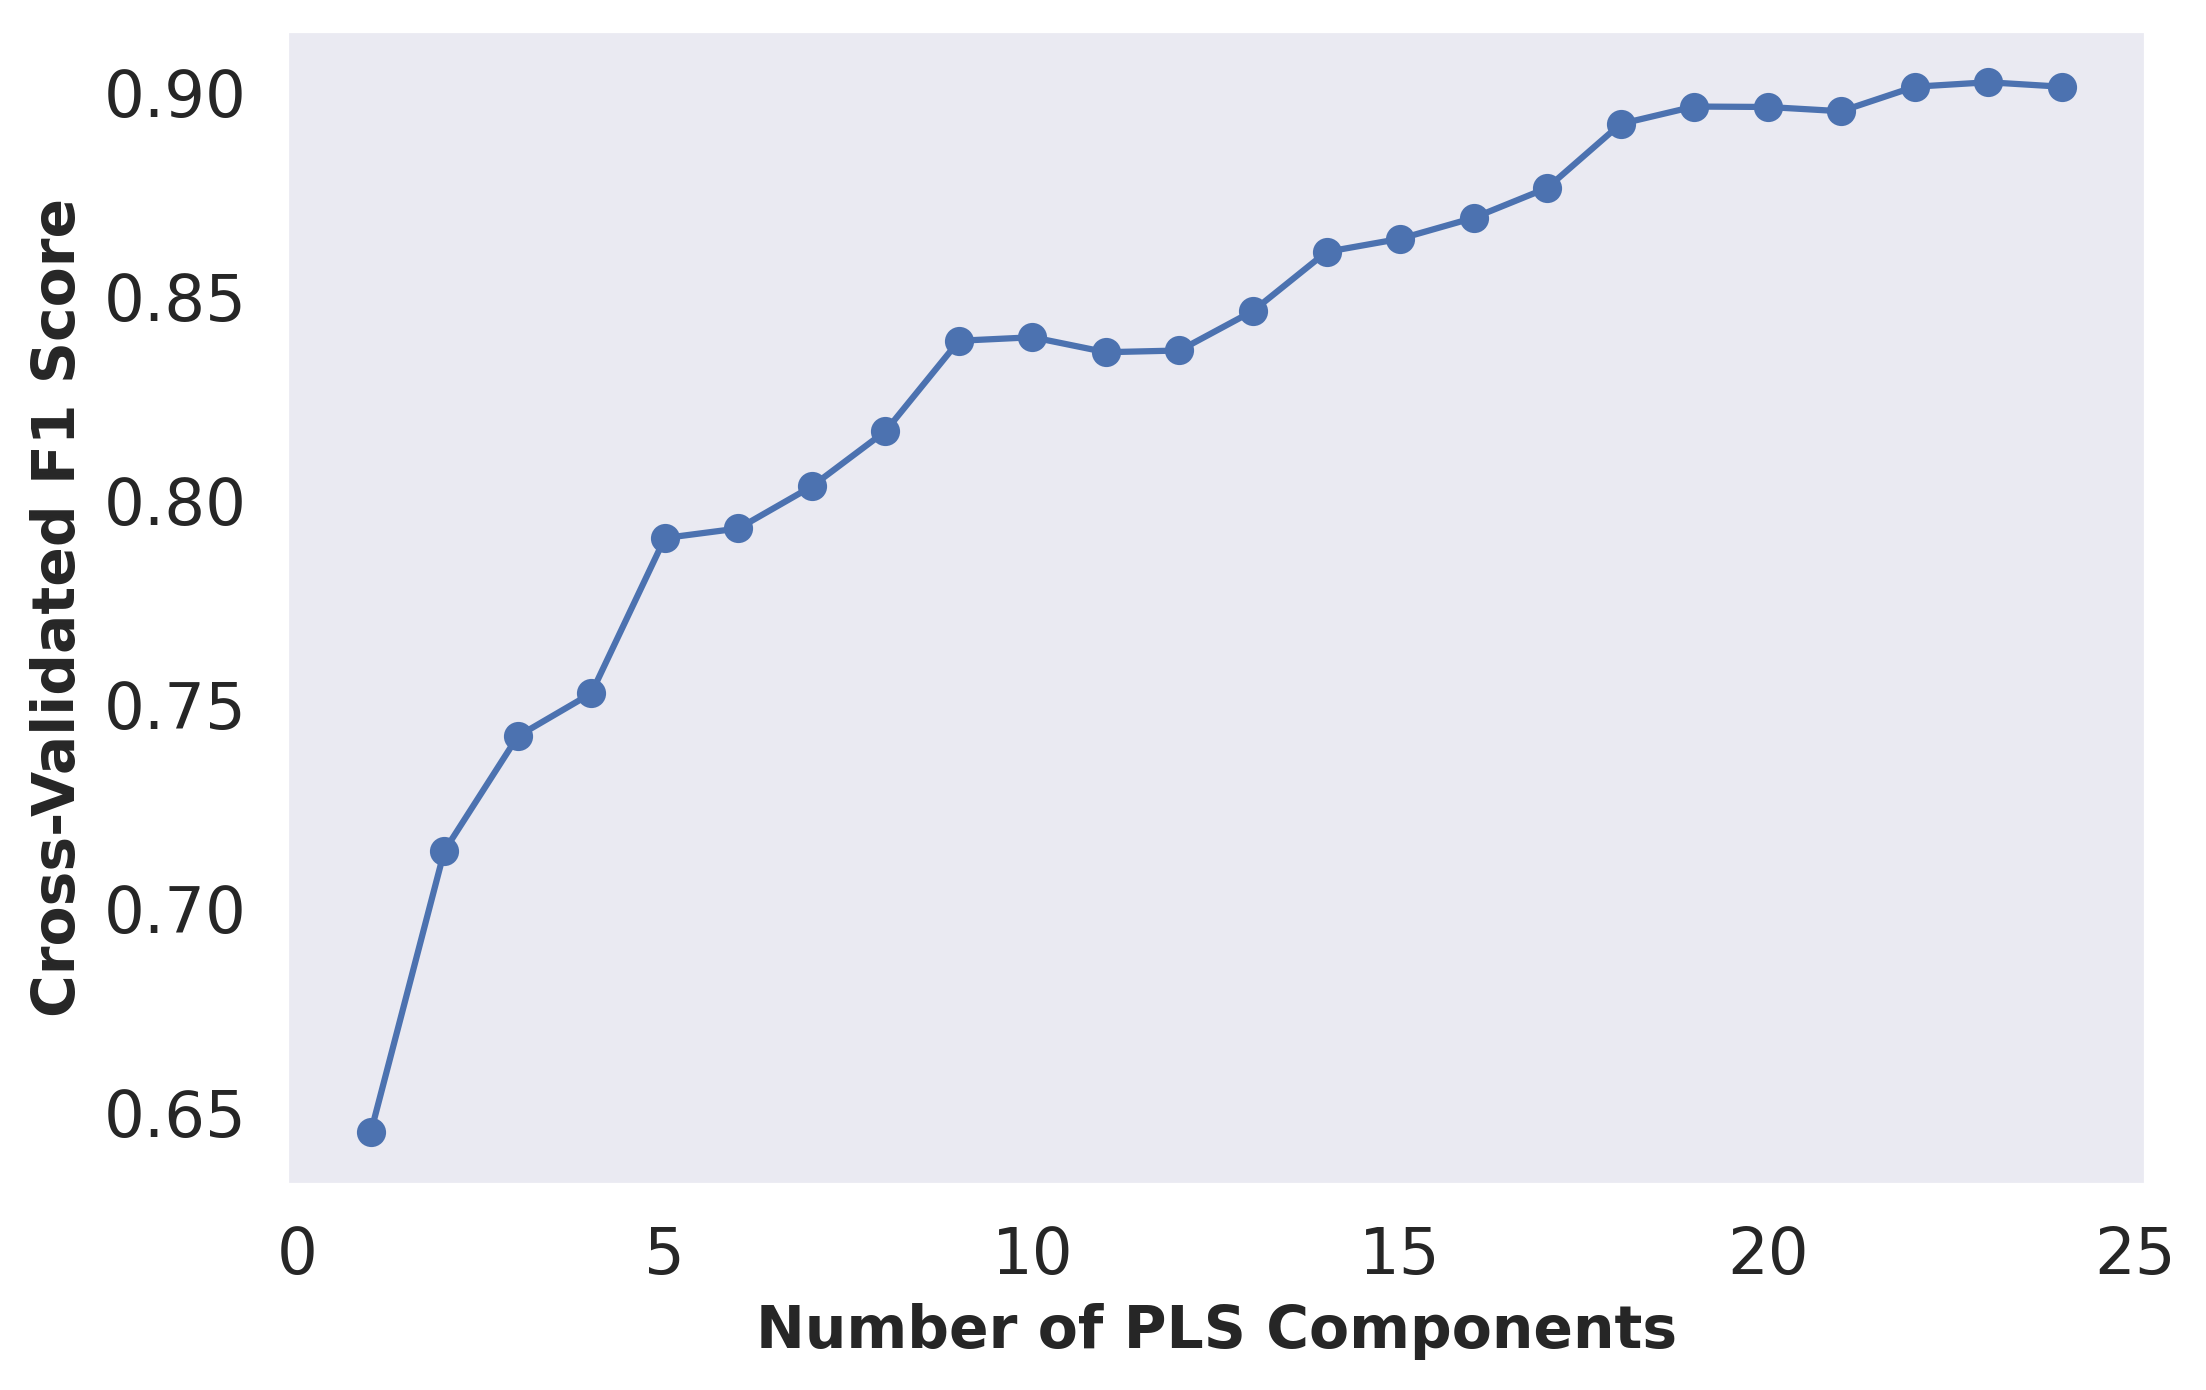

Optimal number of PLS components based on F1 Score: 23
{'Calibration': {'Accuracy': 0.9161816065192084, 'Precision': 0.9198113207547169, 'Recall': 0.9112149532710281, 'F1': 0.9154929577464789}, 'Cross-Validation': {'Accuracy': 0.9033760186263097, 'Precision': 0.9020979020979021, 'Recall': 0.9042056074766355, 'F1': 0.9031505250875146}, 'Validation': {'Accuracy': 0.8972972972972973, 'Precision': 0.8842105263157894, 'Recall': 0.9130434782608695, 'F1': 0.8983957219251337}}


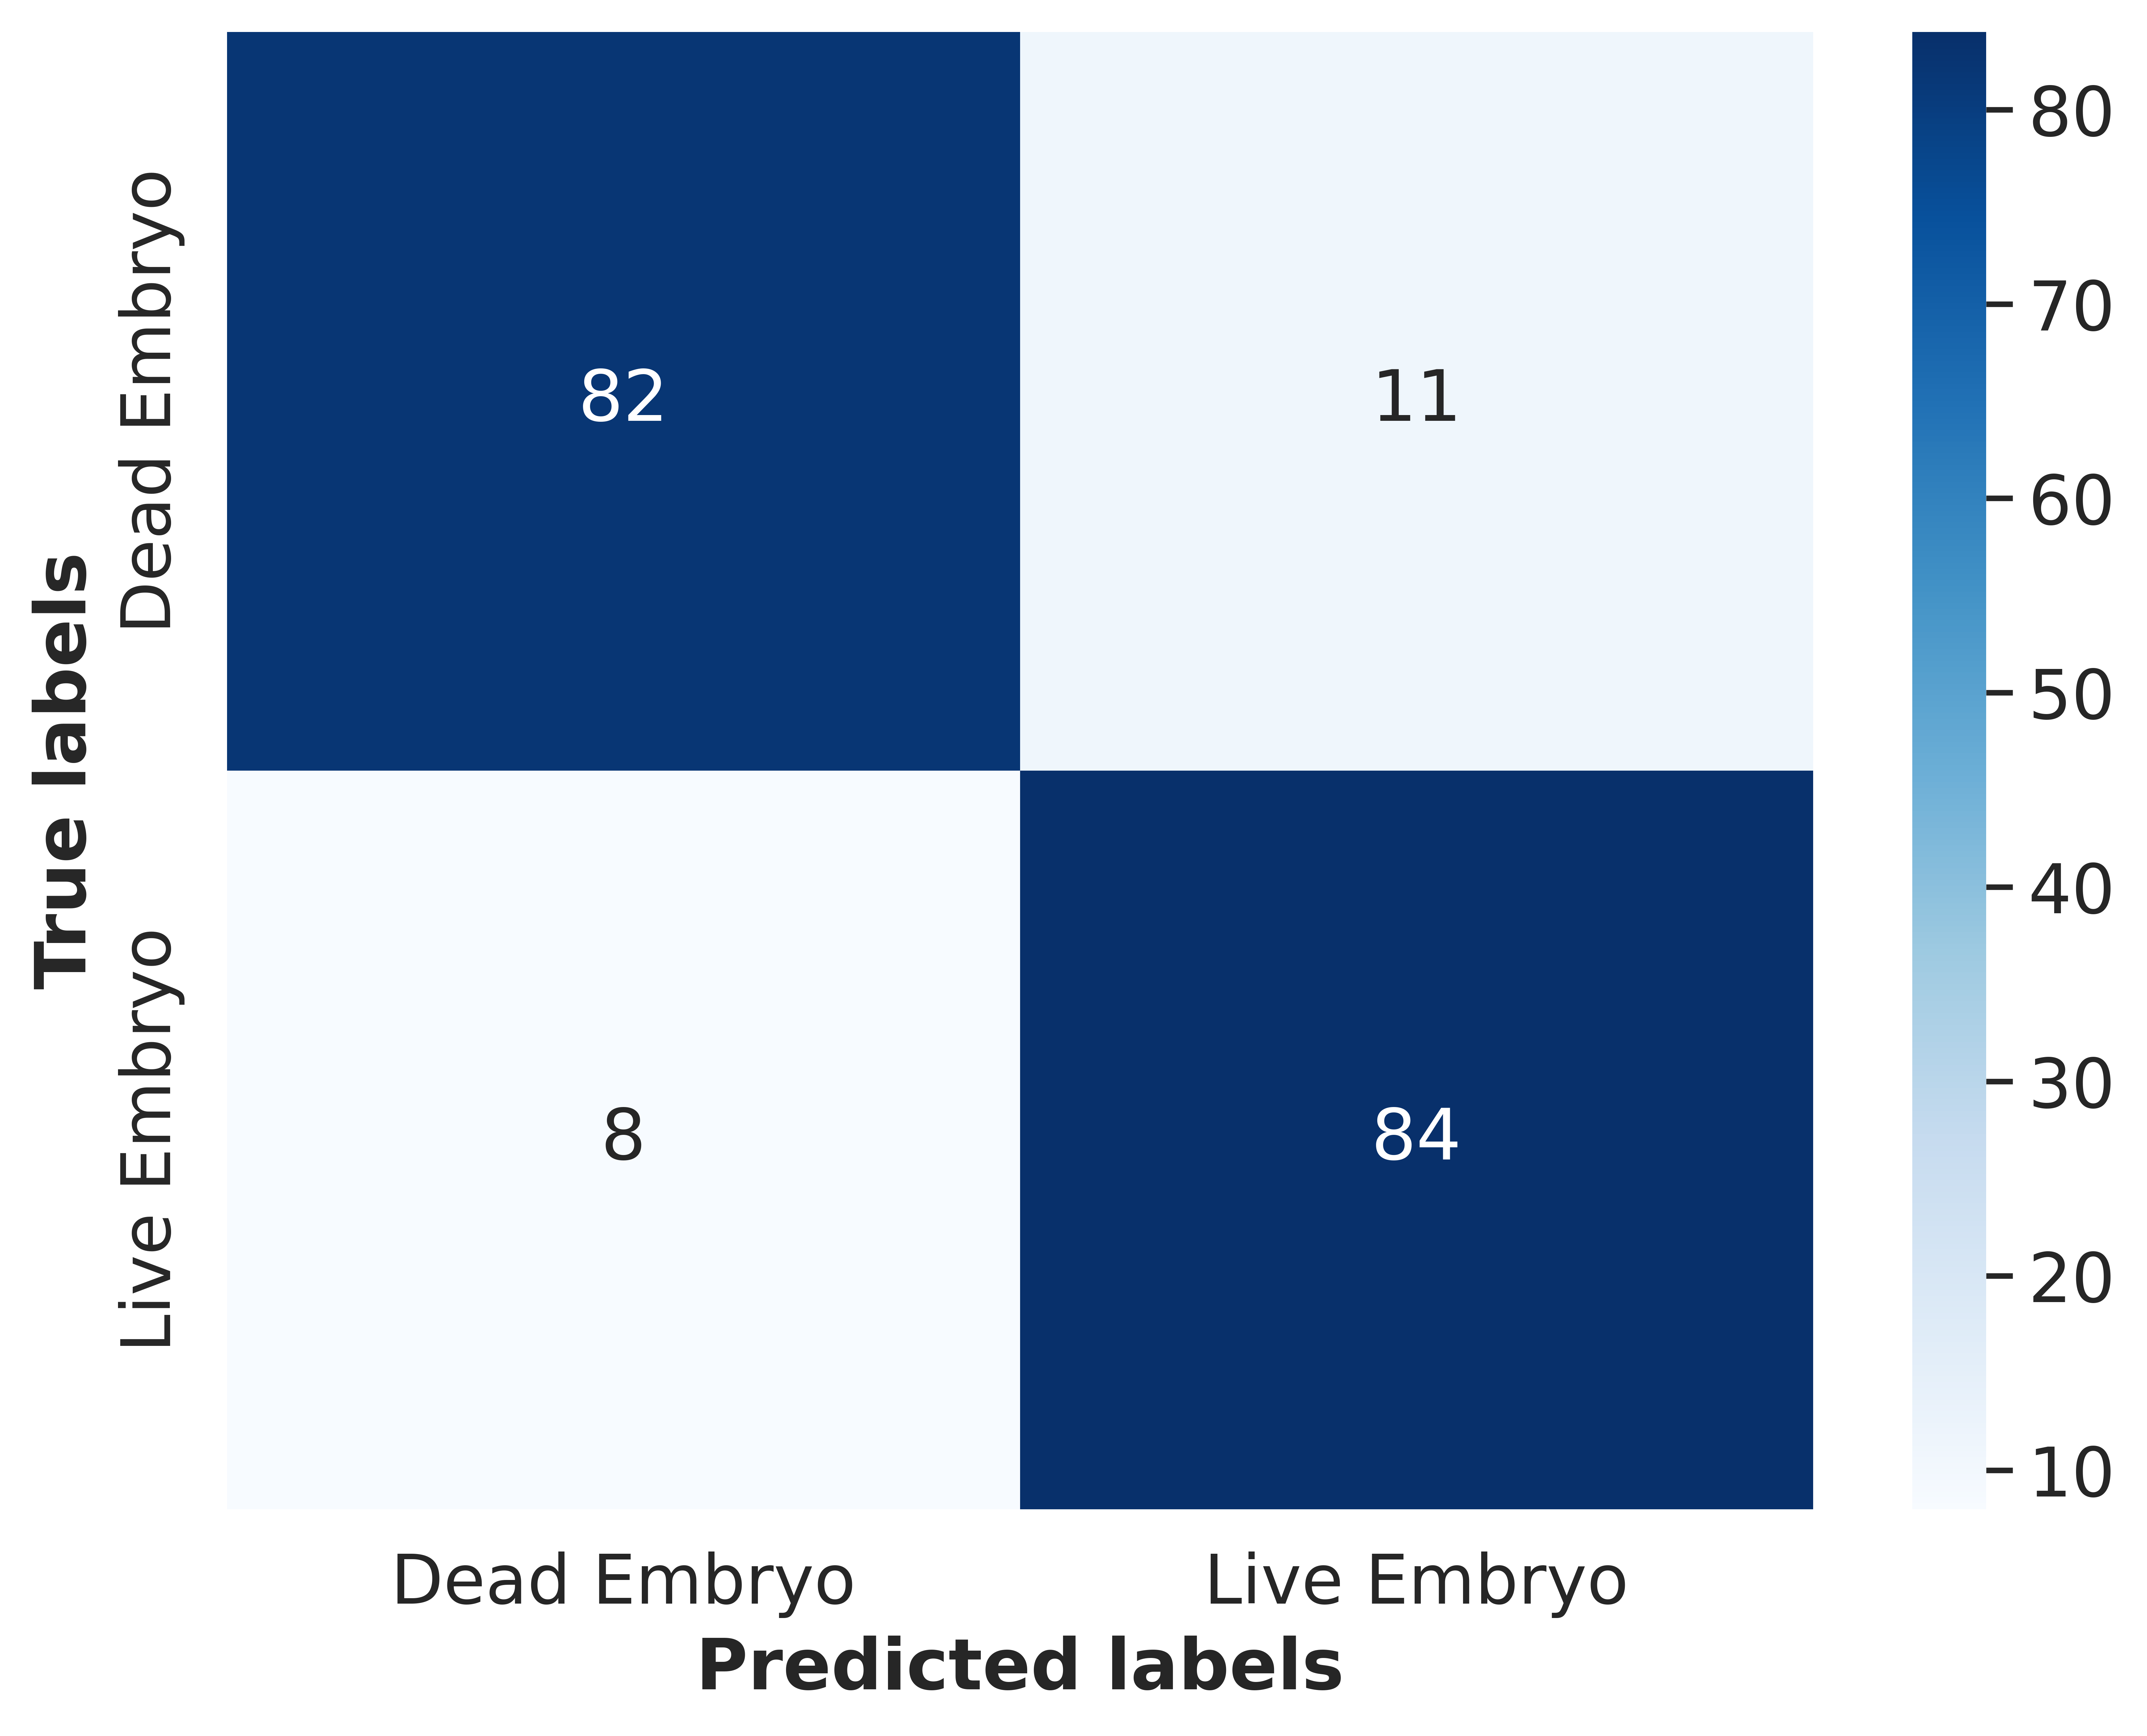

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Function for Standard Normal Variate (SNV) preprocessing
def snv(input_data):
    """Apply Standard Normal Variate (SNV) transformation."""
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

# Load calibration and validation data
calibration_file_path = '/content/Cal_Stratified.csv'
validation_file_path = '/content/Val_Stratified.csv'

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare calibration and validation data
X_cal = calibration_data.drop(columns=['Ref']).values
y_cal = calibration_data['Ref'].values
X_val = validation_data.drop(columns=['Ref']).values
y_val = validation_data['Ref'].values

# Apply SNV transformation
X_cal_snv = snv(X_cal)
X_val_snv = snv(X_val)

# Encode the target variable
label_encoder = LabelEncoder()
y_cal_encoded = label_encoder.fit_transform(y_cal).flatten()
y_val_encoded = label_encoder.transform(y_val).flatten()

# Standardize the data
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal_snv)
X_val_scaled = scaler.transform(X_val_snv)

# Define a custom PLS transformer to ensure correct transformation
class PLSExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)

    def fit(self, X, y):
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)  # Ensure 2D output

# Determine the optimal number of PLS components using F1 Score
n_components_range = range(1, 25)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []
for n in n_components_range:
    pls_da_pipeline = Pipeline(steps=[
        ('pls', PLSExtractor(n_components=n)),
        ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))  # Adjust solver
    ])
    scores = cross_val_score(pls_da_pipeline, X_cal_scaled, y_cal_encoded, cv=cv, scoring=make_scorer(f1_score))
    f1_scores.append(np.mean(scores))

# Plot PLS component selection using F1 score
plt.figure(figsize=(8, 5), dpi=300)
plt.plot(n_components_range, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components', fontsize=14, fontweight='bold')
plt.ylabel('Cross-Validated F1 Score', fontsize=14, fontweight='bold')
#plt.title('PLS Component Selection (F1 Score)', fontsize=16, fontweight='bold')
plt.grid()
plt.show()

# Select optimal number of components
optimal_n_components = n_components_range[np.argmax(f1_scores)]
print(f'Optimal number of PLS components based on F1 Score: {optimal_n_components}')

# Build final PLS-DA model using the optimal number of components
pls_da_model = Pipeline(steps=[
    ('pls', PLSExtractor(n_components=optimal_n_components)),
    ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))
])

# Fit the model on the calibration set
pls_da_model.fit(X_cal_scaled, y_cal_encoded)

# Perform cross-validation
y_cv_pred = cross_val_predict(pls_da_model, X_cal_scaled, y_cal_encoded, cv=cv)

# Predict on the calibration set
y_cal_pred = pls_da_model.predict(X_cal_scaled).round().astype(int)

# Predict on the validation set
y_val_pred = pls_da_model.predict(X_val_scaled).round().astype(int)

# Classification metrics function
def calculate_classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Compute classification metrics
results = {
    "Calibration": calculate_classification_metrics(y_cal_encoded, y_cal_pred),
    "Cross-Validation": calculate_classification_metrics(y_cal_encoded, y_cv_pred),
    "Validation": calculate_classification_metrics(y_val_encoded, y_val_pred)
}

print(results)

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix for validation set with 'Blues' colormap
plt.figure(figsize=(8, 6), dpi=1000)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dead Embryo', 'Live Embryo'],
            yticklabels=['Dead Embryo', 'Live Embryo'],
            annot_kws={"size": 16})
plt.xlabel('Predicted labels', fontsize=16, fontweight='bold')
plt.ylabel('True labels', fontsize=16, fontweight='bold')
plt.show()

**SG first/second derivative + PLS-DA model**

Change the windows lengths and deriv. where necessary

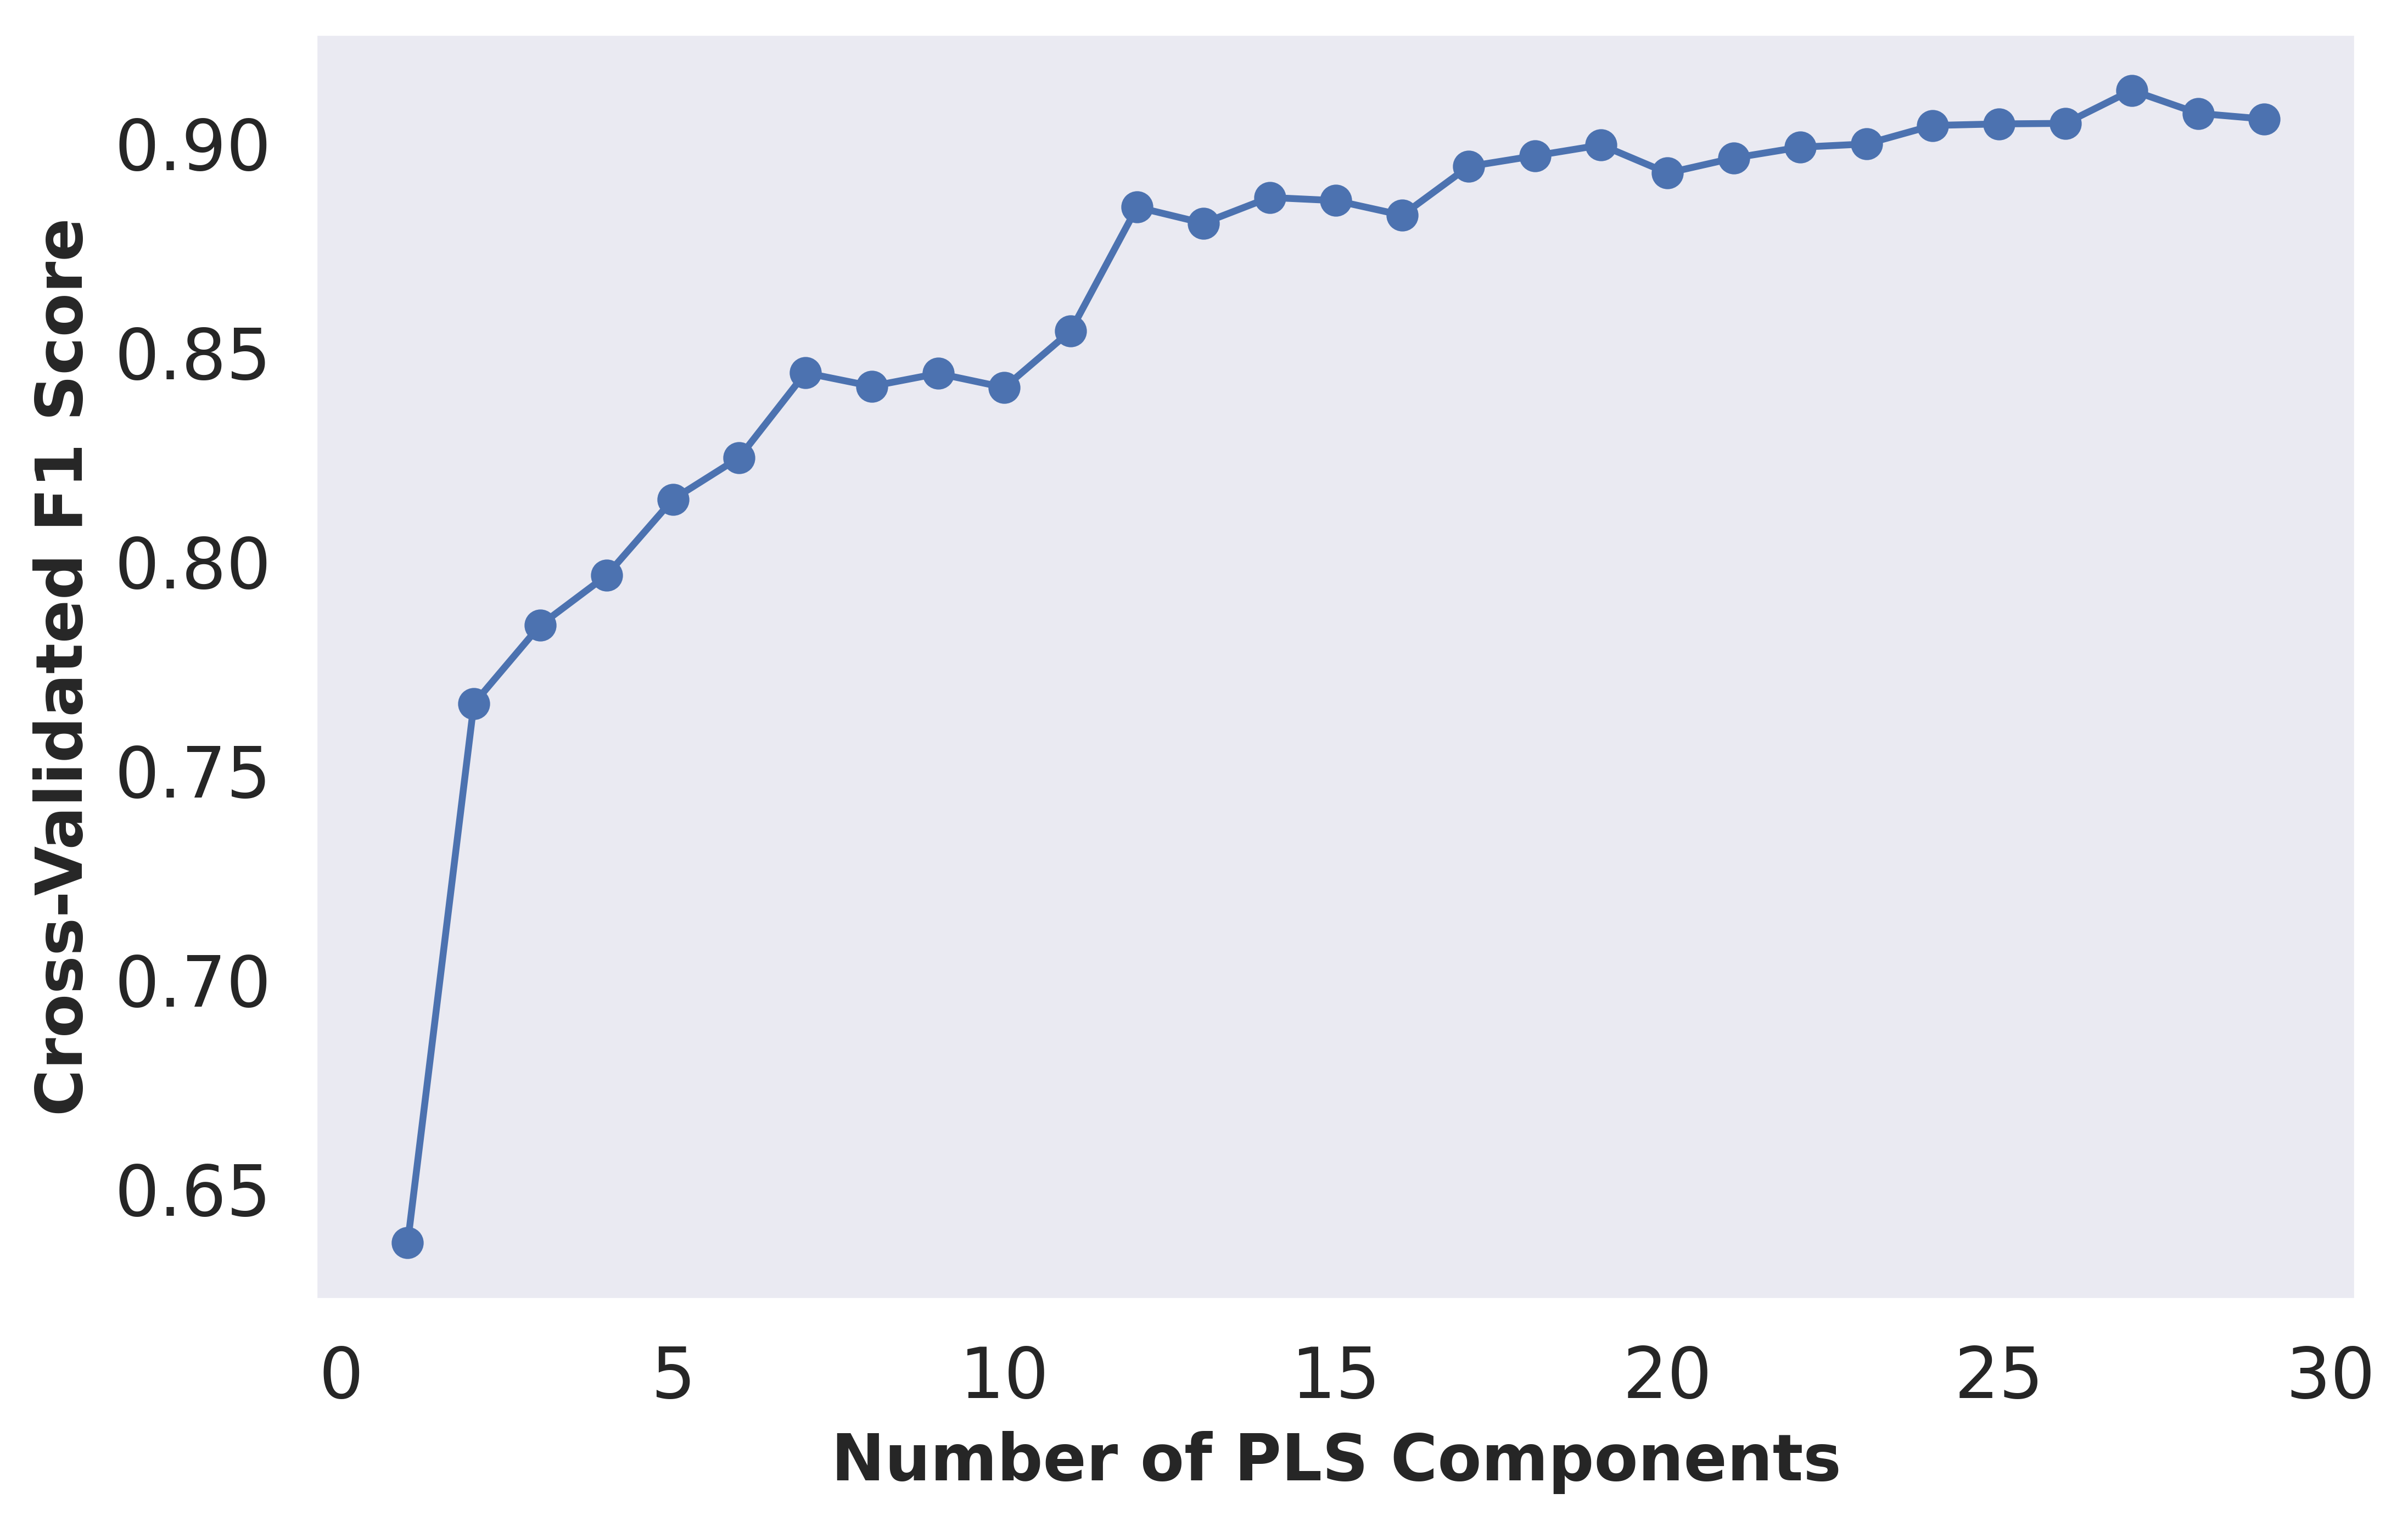

Optimal number of PLS components based on F1 Score: 27
{'Calibration': {'Accuracy': 0.9417927823050058, 'Precision': 0.9354838709677419, 'Recall': 0.9485981308411215, 'F1': 0.9419953596287703}, 'Cross-Validation': {'Accuracy': 0.9126891734575088, 'Precision': 0.9076212471131639, 'Recall': 0.9182242990654206, 'F1': 0.9128919860627178}, 'Validation': {'Accuracy': 0.9027027027027027, 'Precision': 0.9021739130434783, 'Recall': 0.9021739130434783, 'F1': 0.9021739130434783}}


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

# Function for Savitzky-Golay first derivative preprocessing
def sg_first_derivative(input_data, window_length=21, polyorder=2):  ##### Chnage windows length here#########
    """Apply Savitzky-Golay first derivative transformation."""
    return savgol_filter(input_data, window_length=window_length, polyorder=polyorder, deriv=2, axis=1)  ##### Chnage derivative here#########

# Load calibration and validation data
calibration_file_path = '/content/Cal_Stratified.csv'
validation_file_path = '/content/Test_Stratified.csv'

calibration_data = pd.read_csv(calibration_file_path)
validation_data = pd.read_csv(validation_file_path)

# Prepare calibration and validation data
X_cal = calibration_data.drop(columns=['Ref']).values
y_cal = calibration_data['Ref'].values
X_val = validation_data.drop(columns=['Ref']).values
y_val = validation_data['Ref'].values

# Apply SG first derivative transformation
X_cal_sg = sg_first_derivative(X_cal)
X_val_sg = sg_first_derivative(X_val)

# Encode the target variable
label_encoder = LabelEncoder()
y_cal_encoded = label_encoder.fit_transform(y_cal).flatten()
y_val_encoded = label_encoder.transform(y_val).flatten()

# Standardize the data
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal_sg)
X_val_scaled = scaler.transform(X_val_sg)

# Define a custom PLS transformer to ensure correct transformation
class PLSExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)

    def fit(self, X, y):
        self.pls.fit(X, y)
        return self

    def transform(self, X):
        return self.pls.transform(X)  # Ensure 2D output

# Determine the optimal number of PLS components using F1 Score
n_components_range = range(1, 30) ################## Chnage LV range here #################
cv = KFold(n_splits=10, shuffle=True, random_state=42) ########## Change the fold of cross-validation####

f1_scores = []
for n in n_components_range:
    pls_da_pipeline = Pipeline(steps=[
        ('pls', PLSExtractor(n_components=n)),
        ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))  # Adjust solver
    ])
    scores = cross_val_score(pls_da_pipeline, X_cal_scaled, y_cal_encoded, cv=cv, scoring=make_scorer(f1_score))
    f1_scores.append(np.mean(scores))

# Plot PLS component selection using F1 score
plt.figure(figsize=(8, 5), dpi=600) #############Change dpi of plot here#####################
plt.plot(n_components_range, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of PLS Components', fontsize=14, fontweight='bold')
plt.ylabel('Cross-Validated F1 Score', fontsize=14, fontweight='bold')
#plt.title('PLS Component Selection (F1 Score)', fontsize=16, fontweight='bold')
plt.grid()
plt.show()

# Select optimal number of components
optimal_n_components = n_components_range[np.argmax(f1_scores)]
print(f'Optimal number of PLS components based on F1 Score: {optimal_n_components}')

# Build final PLS-DA model using the optimal number of components
pls_da_model = Pipeline(steps=[
    ('pls', PLSExtractor(n_components=optimal_n_components)),
    ('logistic', LogisticRegression(random_state=42, max_iter=500, solver='liblinear'))
])

# Fit the model on the calibration set
pls_da_model.fit(X_cal_scaled, y_cal_encoded)

# Perform cross-validation
y_cv_pred = cross_val_predict(pls_da_model, X_cal_scaled, y_cal_encoded, cv=cv)

# Predict on the calibration set
y_cal_pred = pls_da_model.predict(X_cal_scaled).round().astype(int)

# Predict on the validation set
y_val_pred = pls_da_model.predict(X_val_scaled).round().astype(int)

# Classification metrics function
def calculate_classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

# Compute classification metrics
results = {
    "Calibration": calculate_classification_metrics(y_cal_encoded, y_cal_pred),
    "Cross-Validation": calculate_classification_metrics(y_cal_encoded, y_cv_pred),
    "Validation": calculate_classification_metrics(y_val_encoded, y_val_pred)
}

print(results)

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix for validation set with 'Blues' colormap
plt.figure(figsize=(8, 6), dpi=1500)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='RdPu', ## try cmap='Greens' for Val and 'RdPu' for test set##
            xticklabels=['Infertile', 'Fertile'],
            yticklabels=['Infertile', 'Fertile'],
            annot_kws={"size": 16})
plt.xlabel('Predicted labels', fontsize=16, fontweight='bold')
plt.ylabel('True labels', fontsize=16, fontweight='bold')
plt.show()